# 1 - Introducing data science workflows


** From [https://github.com/ivanovitchm/EEC1509_MachineLearning](https://github.com/ivanovitchm/EEC1509_MachineLearning/tree/master/Lesson%20%2311%20-%20Kaggle%20Fundamentals).**

In this guided project, we're going to put together all that we've learned in this course and create a data science workflow.

By defining a workflow for yourself, you can give yourself a framework with which to make iterating on ideas quicker and easier, allowing yourself to work more efficiently.

In this mission, we're going to explore a workflow to make competing in the Kaggle Titanic competition easier, using a pipeline of functions to reduce the number of dimensions you need to focus on.

To get started, we'll read in the original **train.csv** and **test.csv** files from Kaggle.



In [0]:
#!mkdir data predictions
#!mv holdout_modified.csv train_modified.csv train.csv test.csv data

In [0]:
import pandas as pd

train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")

In [52]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [53]:
holdout.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [0]:
survived = train["Survived"]
train = train.drop("Survived",axis=1)

In [55]:
holdout.shape

(418, 11)

In [56]:
train.shape

(891, 11)

In [0]:
## concatenate all data to guarantee that dataset have the same columns
all_data = pd.concat([train,holdout],axis=0)

In [58]:
all_data.shape

(1309, 11)

#2 - Exploring the Data




In the first three missions of this course, we have done a variety of activities, mostly in isolation: **Exploring the data**, **creating features**, **selecting features**, **selecting and tuning different models**.

The Kaggle workflow we are going to build will combine all of these into a process.

<img width="400" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1swb6PxXUJuDvv83ylqh9eUh992lXTu47">

- **Data exploration**, to find patterns in the data
- **Feature engineering**, to create new features from those patterns or through pure experimentation
- **Feature selection**, to select the best subset of our current set of features
- **Model selection/tuning**, training a number of models with different hyperparameters to find the best performer.

We can continue to repeat this cycle as we work to optimize our predictions. At the end of any cycle we wish, we can also use our model to make predictions on the holdout set and then **Submit to Kaggle** to get a leaderboard score.

While the first two steps of our workflow are relatively freeform, later in this project we'll create some functions that will help automate the complexity of the latter two steps so we can move faster.

For now, let's practice the first stage, exploring the data. We're going to examine the two columns that contain information about the family members each passenger had onboard: **SibSp** and **Parch**.

# 3 - Preprocesing the Data

In [0]:
def process_ticket(df):
    # see https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling
    Ticket = []
    for i in list(df.Ticket):
        if not i.isdigit():
            #Take prefix
            Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) 
        else:
            Ticket.append("X")
    df["Ticket"] = Ticket
    return df

def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(df["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    
    #df = df.drop("Age",axis=1)
    
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    
    df = df.drop("Fare",axis=1)
    
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [0]:
def pre_process(df):
    df = process_ticket(df)
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)

    for col in ["Age_categories","Fare_categories",
                "Title","Cabin_type","Sex","Ticket","Pclass"]:
        df = create_dummies(df,col)
    
    #df = df.drop(["Age_categories","Fare_categories",
                #"Title","Cabin_type","Sex","Ticket"],axis=1)
    
    return df

all_data = pre_process(all_data)

train = all_data.iloc[:891]
train = pd.concat([train,survived],axis=1)
holdout = all_data.iloc[891:]


#4 - Exploring Data



In [61]:
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()
explore.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 3 columns):
SibSp       891 non-null int64
Parch       891 non-null int64
Survived    891 non-null int64
dtypes: int64(3)
memory usage: 27.8 KB


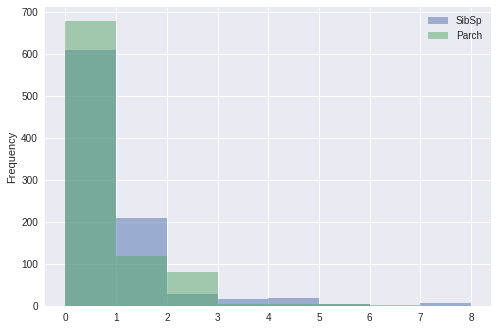

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

explore.drop("Survived",axis=1).plot.hist(alpha=0.5,bins=8)
plt.show()

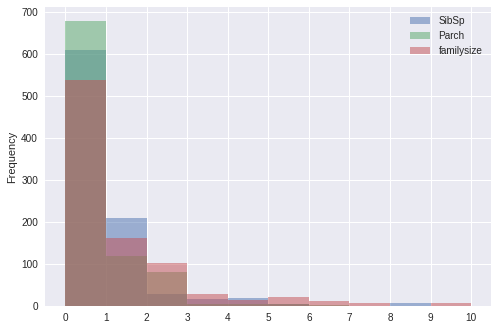

In [63]:
explore["familysize"] = explore[["SibSp","Parch"]].sum(axis=1)
explore.drop("Survived",axis=1).plot.hist(alpha=0.5,bins=10)
plt.xticks(range(11))
plt.show()

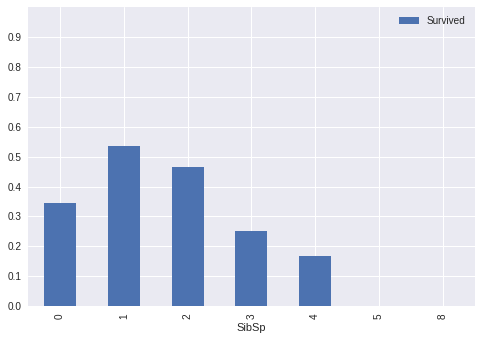

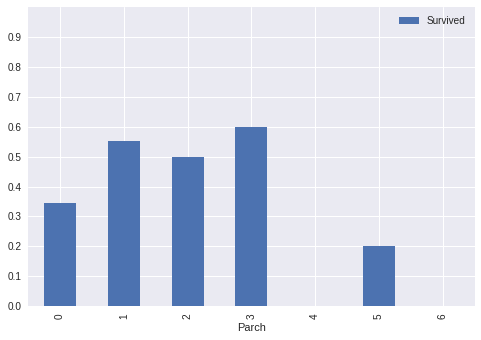

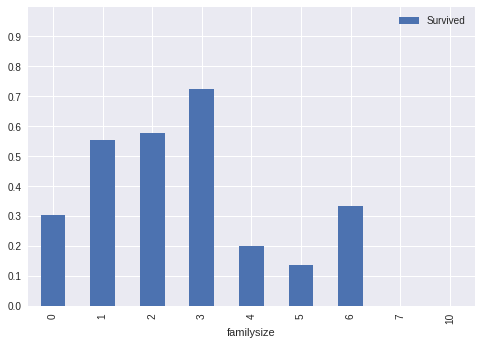

In [64]:
import numpy as np
plt.clf()
for col in explore.columns.drop("Survived"):
    pivot = explore.pivot_table(index=col,values="Survived")
    pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
    plt.show()

The SibSp column shows the number of siblings and/or spouses each passenger had on board, while the Parch columns shows the number of parents or children each passenger had onboard. Neither column has any missing values.

The distribution of values in both columns is skewed right, with the majority of values being zero.

You can sum these two columns to explore the total number of family members each passenger had onboard. The shape of the distribution of values in this case is similar, however there are less values at zero, and the quantity tapers off less rapidly as the values increase.

Looking at the survival rates of the the combined family members, you can see that few of the over 500 passengers with no family members survived, while greater numbers of passengers with family members survived.

#5 - Engineering New Features


In [65]:
def process_isalone(df):
    df["familysize"] = df[["SibSp","Parch"]].sum(axis=1)
    df["isalone"] = 0
    df.loc[(df["familysize"] == 0),"isalone"] = 1
    #df = df.drop("familysize",axis=1)
    return df

train = process_isalone(train)
holdout = process_isalone(holdout)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

#6 - Selecting the Best-Performing Features


In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

def select_features(df,index):
    
    # index
    # 0 - random forest
    # 1 - logistic regression
    
    # Remove non-numeric columns, columns that have null values
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(["Survived","PassengerId"],axis=1)
    all_y = df["Survived"]
    
    clf_rf = RandomForestClassifier(random_state=1, n_estimators=100)
    clf_lr = LogisticRegression()
    clfs = [clf_rf,clf_lr]
    
    selector = RFECV(clfs[index],cv=10,n_jobs=-1)
    selector.fit(all_X,all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))
    
    return best_columns

cols_rf = select_features(train,0)
cols_lr = select_features(train,1)

Best Columns 
------------
['Pclass', 'Age', 'SibSp', 'Parch', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Child', 'Age_categories_Teenager', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'Ticket_A4', 'Ticket_A5', 'Ticket_AS', 'Ticket_C', 'Ticket_CA', 'Ticket_CASOTON', 'Ticket_FC', 'Ticket_FCC', 'Ticket_LINE', 'Ticket_PC', 'Ticket_PP', 'Ticket_PPP', 'Ticket_SC', 'Ticket_SCAH', 'Ticket_SCOW', 'Ticket_SCPARIS', 'Ticket_SCParis', 'Ticket_SOC', 'Ticket_SOP', 'Ticket_SOPP', 'Ticket_SOTONO2', 'Ticket_SOTONOQ', 'Ticket_SP', 'Ticket_STONO', 'Ticket_STONO2', 'Ticket_SWPP', 'Ticket_W

In [67]:
print(len(cols_rf), cols_rf)
print(len(cols_lr), cols_lr)

66 ['Pclass', 'Age', 'SibSp', 'Parch', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Child', 'Age_categories_Teenager', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'Ticket_A4', 'Ticket_A5', 'Ticket_AS', 'Ticket_C', 'Ticket_CA', 'Ticket_CASOTON', 'Ticket_FC', 'Ticket_FCC', 'Ticket_LINE', 'Ticket_PC', 'Ticket_PP', 'Ticket_PPP', 'Ticket_SC', 'Ticket_SCAH', 'Ticket_SCOW', 'Ticket_SCPARIS', 'Ticket_SCParis', 'Ticket_SOC', 'Ticket_SOP', 'Ticket_SOPP', 'Ticket_SOTONO2', 'Ticket_SOTONOQ', 'Ticket_SP', 'Ticket_STONO', 'Ticket_STONO2', 'Ticket_SWPP', 'Ticket_WC', 'Ticket_WEP', 'Ticke

#7 - Selecting and Tuning Different Algorithms


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
import numpy as np

def select_model(df,features):
    
    all_X = df[features]
    all_y = df["Survived"]

    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [200],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [10,20],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1],
                    "min_samples_split": [2]
                }
        },
        {
            "name":"SVC",
            "estimator":SVC(),
            "hyperparameters":
                {
                  "kernel": ['rbf'],  
                  "C": [0.001, 0.01, 0.1, 1, 10],
                  "gamma": [0.001, 0.01, 0.1, 1]
                }
        },
        {
            # reference
            # https://github.com/UltravioletAnalytics/kaggle-titanic/blob/master/sgdclassifier.py
            "name":"SGDC",
            "estimator": SGDClassifier(),
            "hyperparameters":
            {
                "loss": ["log"],
                "alpha": [0.001],
                "penalty": ["elasticnet"],
                "l1_ratio": [0.8],
                "shuffle": [True],
                "learning_rate": ['optimal'],
                "max_iter":[1000]
            }
        }
    ]

    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10)
        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

In [69]:
result_a = select_model(train,cols_rf)

LogisticRegression
------------------
Best Score: 0.819304152637486
Best Parameters: {'solver': 'newton-cg'}

KNeighborsClassifier
--------------------
Best Score: 0.8204264870931538
Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}

RandomForestClassifier
----------------------
Best Score: 0.8395061728395061
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

SVC
---
Best Score: 0.8294051627384961
Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

SGDC
----
Best Score: 0.7968574635241302
Best Parameters: {'alpha': 0.001, 'l1_ratio': 0.8, 'learning_rate': 'optimal', 'loss': 'log', 'max_iter': 1000, 'penalty': 'elasticnet', 'shuffle': True}



In [70]:
result_b = select_model(train,cols_lr)

LogisticRegression
------------------
Best Score: 0.8249158249158249
Best Parameters: {'solver': 'newton-cg'}

KNeighborsClassifier
--------------------
Best Score: 0.8327721661054994
Best Parameters: {'algorithm': 'brute', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}

RandomForestClassifier
----------------------
Best Score: 0.8361391694725028
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

SVC
---
Best Score: 0.8361391694725028
Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

SGDC
----
Best Score: 0.8226711560044894
Best Parameters: {'alpha': 0.001, 'l1_ratio': 0.8, 'learning_rate': 'optimal', 'loss': 'log', 'max_iter': 1000, 'penalty': 'elasticnet', 'shuffle': True}



#8 - Making a Submission to Kaggle


In [0]:
def save_submission_file(model,cols,filename):
    holdout_data = holdout[cols]
    predictions = model.predict(holdout_data)
    
    holdout_ids = holdout["PassengerId"]
    submission_df = {"PassengerId": holdout_ids,
                 "Survived": predictions}
    submission = pd.DataFrame(submission_df)

    submission.to_csv(filename,index=False)

In [0]:
best_rf_model = result_b[3]["best_model"]
save_submission_file(best_rf_model,cols_lr,"submission_PreprocessingIvanovitch.csv")

#9 - Next Steps




We encourage you to continue working on this Kaggle competition. Here are some suggestions of next steps:

- Continue to explore the data and create new features, following the workflow and using the functions we created.
- Read more about the titanic and this Kaggle competition to get ideas for new features.
- Use some different algorithms in the select_model() function, like [stochastic gradient descent](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) or [perceptron linear models](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html).
- Experiment with [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) instead of **GridSearchCV** to speed up your **select_features()** function.

Lastly, while the Titanic competition is great for learning about how to approach your first Kaggle competition, we recommend against spending many hours focused on trying to get to the top of the leaderboard. With such a small data set, there is a limit to how good your predictions can be, and your time would be better spent moving onto more complex competitions.

Once you feel like you have a good understanding of the Kaggle workflow, you should look at some other competitions - a great next competition is the [House Prices Competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). A start point you can find [here](https://www.dataquest.io/blog/kaggle-getting-started/).

# 10 - Loading the modified data

In [0]:
import pandas as pd

train_mod = pd.read_csv("train_modified.csv")
holdout_mod = pd.read_csv("holdout_modified.csv")

In [74]:
print(train_mod.info())
train_mod.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 39 columns):
Survived                      891 non-null int64
PassengerId                   891 non-null int64
Age_categories_Missing        891 non-null int64
Age_categories_Infant         891 non-null int64
Age_categories_Child          891 non-null int64
Age_categories_Teenager       891 non-null int64
Age_categories_Young Adult    891 non-null int64
Age_categories_Adult          891 non-null int64
Age_categories_Senior         891 non-null int64
Pclass_1                      891 non-null int64
Pclass_2                      891 non-null int64
Pclass_3                      891 non-null int64
Sex_female                    891 non-null int64
Sex_male                      891 non-null int64
Embarked_C                    891 non-null int64
Embarked_Q                    891 non-null int64
Embarked_S                    891 non-null int64
SibSp_scaled                  891 non-null float64
Parch_scale

,Survived,PassengerId,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior,Pclass_1,...,Title_Royalty,Cabin_type_A,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown
0,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,2,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
2,1,3,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,4,0,0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,0,5,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [75]:
print(holdout_mod.info())
holdout_mod.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 38 columns):
PassengerId                   418 non-null int64
Age_categories_Missing        418 non-null int64
Age_categories_Infant         418 non-null int64
Age_categories_Child          418 non-null int64
Age_categories_Teenager       418 non-null int64
Age_categories_Young Adult    418 non-null int64
Age_categories_Adult          418 non-null int64
Age_categories_Senior         418 non-null int64
Pclass_1                      418 non-null int64
Pclass_2                      418 non-null int64
Pclass_3                      418 non-null int64
Sex_female                    418 non-null int64
Sex_male                      418 non-null int64
Embarked_C                    418 non-null int64
Embarked_Q                    418 non-null int64
Embarked_S                    418 non-null int64
SibSp_scaled                  418 non-null float64
Parch_scaled                  418 non-null float64
Fare_scal

,PassengerId,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior,Pclass_1,Pclass_2,...,Title_Royalty,Cabin_type_A,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown
0,892,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,893,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,894,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
3,895,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,896,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [0]:
X_mod = train_mod.drop(["Survived","PassengerId"],axis=1)
y_mod = train_mod["Survived"]

# 11 - Using the  AdaBoostClassifier

An AdaBoost [1] classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

This class implements the algorithm known as AdaBoost-SAMME [2].

class **sklearn.ensemble.AdaBoostClassifier**(base_estimator=None, n_estimators=50, learning_rate=1.0, algorithm=’SAMME.R’, random_state=None)[source]


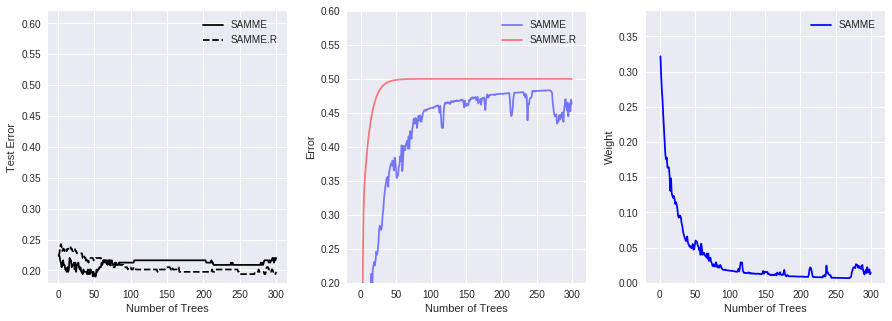

In [77]:
from sklearn.externals.six.moves import zip

import matplotlib.pyplot as plt

from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_mod, y_mod, test_size=0.3, random_state=42)


bdt_real = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=15),
    n_estimators=300,
    learning_rate=0.1)

bdt_discrete = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=15),
    n_estimators=300,
    learning_rate=0.1,
    algorithm="SAMME")

bdt_real.fit(X_train, y_train)
bdt_discrete.fit(X_train, y_train)

real_test_errors = []
discrete_test_errors = []

for real_test_predict, discrete_train_predict in zip(
        bdt_real.staged_predict(X_test), bdt_discrete.staged_predict(X_test)):
    real_test_errors.append(
        1. - accuracy_score(real_test_predict, y_test))
    discrete_test_errors.append(
        1. - accuracy_score(discrete_train_predict, y_test))

n_trees_discrete = len(bdt_discrete)
n_trees_real = len(bdt_real)

# Boosting might terminate early, but the following arrays are always
# n_estimators long. We crop them to the actual number of trees here:
discrete_estimator_errors = bdt_discrete.estimator_errors_[:n_trees_discrete]
real_estimator_errors = bdt_real.estimator_errors_[:n_trees_real]
discrete_estimator_weights = bdt_discrete.estimator_weights_[:n_trees_discrete]

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(range(1, n_trees_discrete + 1),
         discrete_test_errors, c='black', label='SAMME')
plt.plot(range(1, n_trees_real + 1),
         real_test_errors, c='black',
         linestyle='dashed', label='SAMME.R')
plt.legend()
plt.ylim(0.18, 0.62)
plt.ylabel('Test Error')
plt.xlabel('Number of Trees')

plt.subplot(132)
plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_errors,
         "b", label='SAMME', alpha=.5)
plt.plot(range(1, n_trees_real + 1), real_estimator_errors,
         "r", label='SAMME.R', alpha=.5)
plt.legend()
plt.ylabel('Error')
plt.xlabel('Number of Trees')
plt.ylim((.2,
         max(real_estimator_errors.max(),
             discrete_estimator_errors.max()) * 1.2))
plt.xlim((-20, len(bdt_discrete) + 20))

plt.subplot(133)
plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_weights,
         "b", label='SAMME')
plt.legend()
plt.ylabel('Weight')
plt.xlabel('Number of Trees')
plt.ylim((0, discrete_estimator_weights.max() * 1.2))
plt.xlim((-20, n_trees_discrete + 20))

# prevent overlapping y-axis labels
plt.subplots_adjust(wspace=0.25)
plt.show()

In [78]:
bdt_real

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.1, n_estimators=300, random_state=None)

In [79]:
print(real_test_errors)
print(discrete_test_errors)

[0.22388059701492535, 0.2276119402985075, 0.23880597014925375, 0.2425373134328358, 0.23880597014925375, 0.23134328358208955, 0.2350746268656716, 0.2350746268656716, 0.23134328358208955, 0.23134328358208955, 0.2350746268656716, 0.23134328358208955, 0.2350746268656716, 0.2350746268656716, 0.2350746268656716, 0.2350746268656716, 0.23880597014925375, 0.2350746268656716, 0.2350746268656716, 0.23134328358208955, 0.23134328358208955, 0.2350746268656716, 0.2350746268656716, 0.23134328358208955, 0.23134328358208955, 0.2276119402985075, 0.2276119402985075, 0.2276119402985075, 0.2276119402985075, 0.2276119402985075, 0.2276119402985075, 0.2276119402985075, 0.2276119402985075, 0.2201492537313433, 0.2201492537313433, 0.22388059701492535, 0.2201492537313433, 0.2201492537313433, 0.2126865671641791, 0.21641791044776115, 0.21641791044776115, 0.2126865671641791, 0.2201492537313433, 0.2201492537313433, 0.2201492537313433, 0.2201492537313433, 0.2201492537313433, 0.2201492537313433, 0.21641791044776115, 0.2

In [80]:
print(bdt_real.score(X_test, y_test))
print(bdt_discrete.score(X_test, y_test))

0.8022388059701493
0.7798507462686567


In [81]:
# make the prediction using the resulting model
holdout_pred = holdout_mod.drop(["PassengerId"],axis=1)

predictions = bdt_real.predict(holdout_pred)

print("class = ", predictions)

holdout_ids = holdout_mod["PassengerId"]
submission_df = {"PassengerId": holdout_ids, "Survived": predictions}
submission = pd.DataFrame(submission_df)
submission.to_csv("submission_AdaBoostClassifier_real_0.csv",index=False)


class =  [0 1 1 1 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 0 0
 1 1 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 1 1 0 1 0 0 1 1 0 0
 1 0 0 1 0 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 1 0 1 0 0 0 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 0 0 1 0 0 0]


In [82]:
# make the prediction using the resulting model
holdout_pred = holdout_mod.drop(["PassengerId"],axis=1)

predictions = bdt_discrete.predict(holdout_pred)

print("class = ", predictions)

holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids, "Survived": predictions}
submission = pd.DataFrame(submission_df)
submission.to_csv("submission_AdaBoostClassifier_discrete_0.csv",index=False)

class =  [0 1 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 1 0 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 0 1 0 0 1 0 0 0 1 1 1 1 1 0 0 1 0 1
 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0
 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0
 1 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0
 1 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1 0
 1 1 0 0 1 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 1 1 1 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 0 0 1 0 0 1]


## 11.1 Plot feature importance of AdaBoostClassifier Discrete

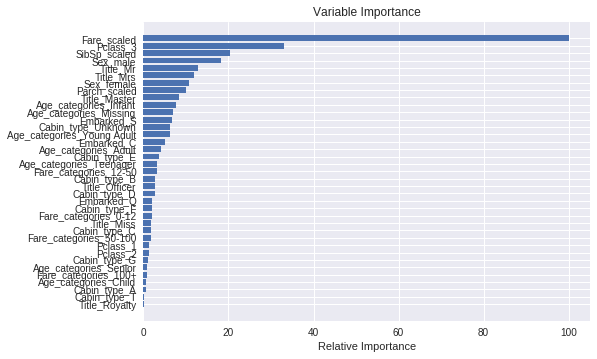

In [83]:

import numpy as np
import matplotlib.pyplot as plt


# #############################################################################
# Plot feature importance
feature_importance = bdt_discrete.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
#plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_mod.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

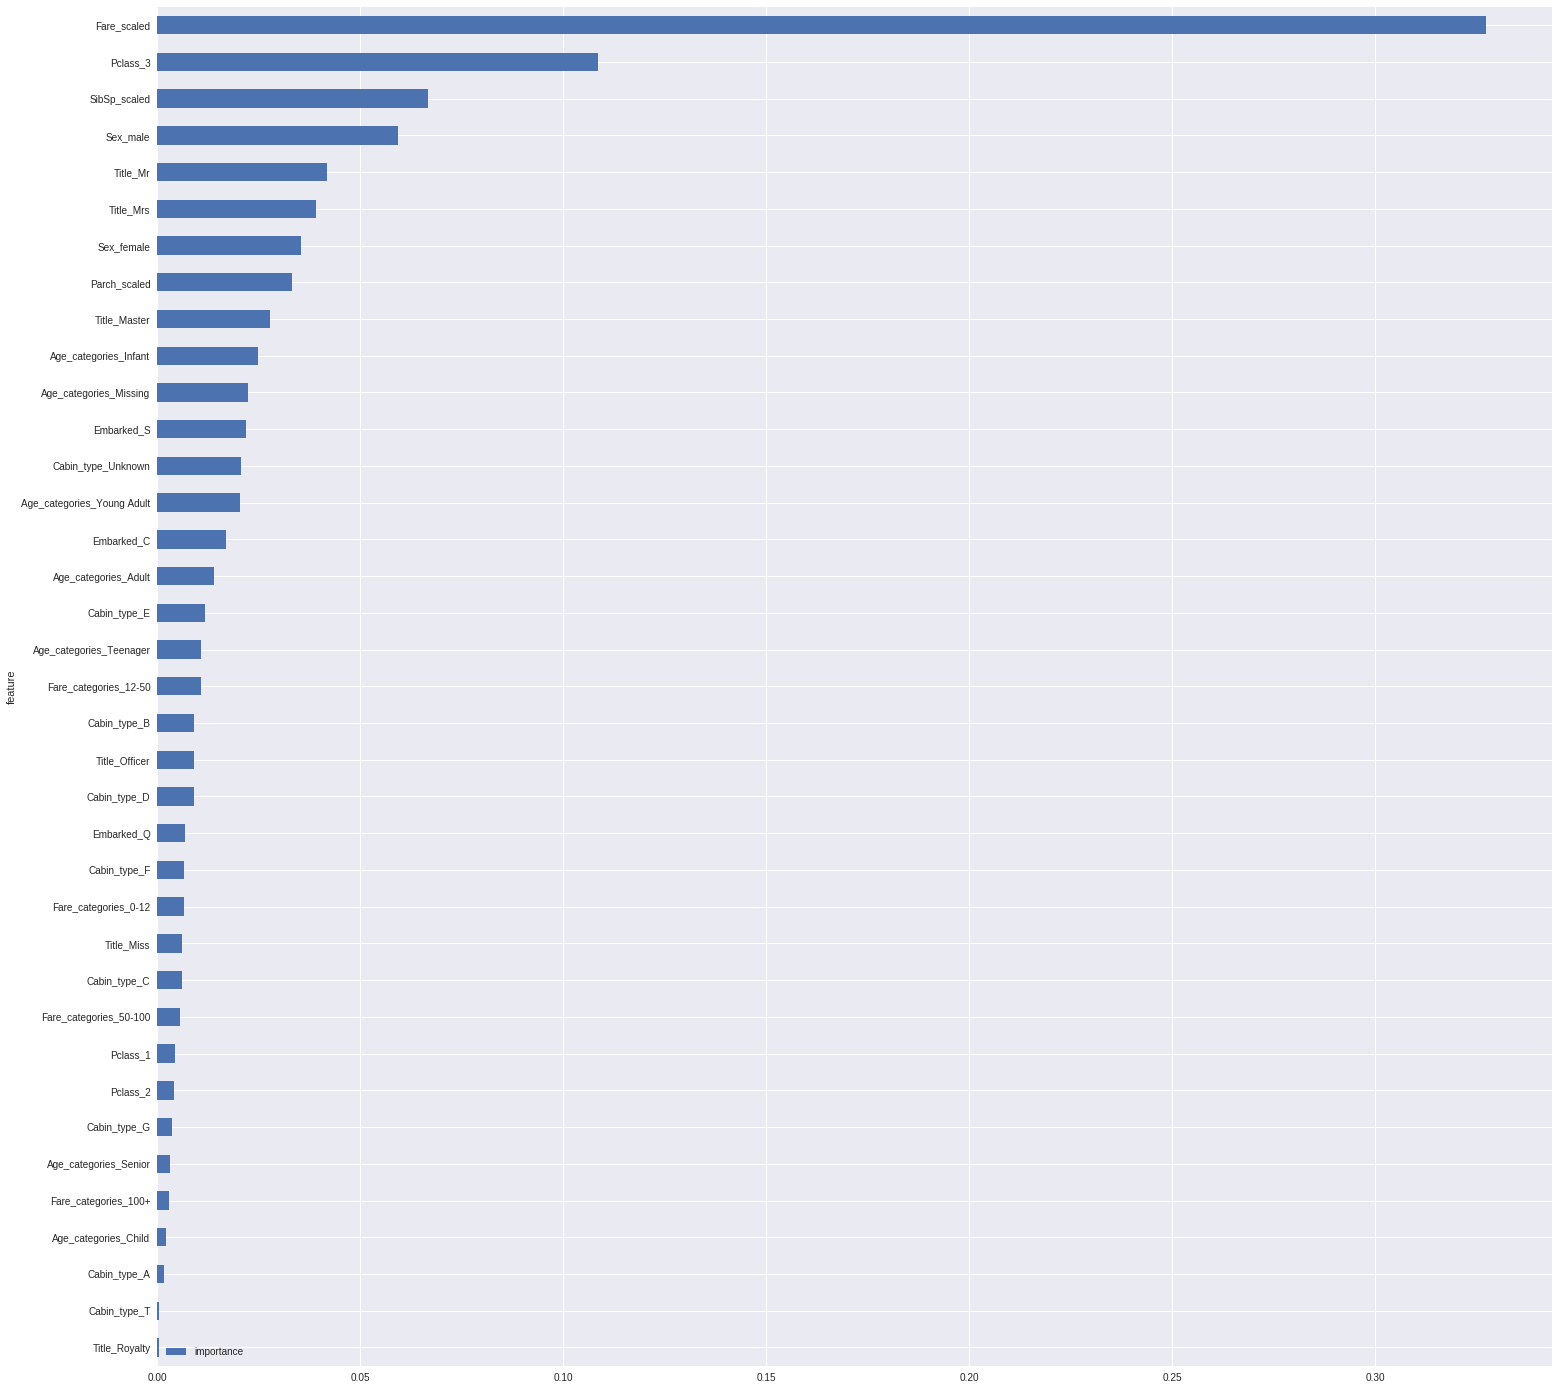

In [84]:
features = pd.DataFrame()
features['feature'] = X_mod.columns
features['importance'] = bdt_discrete.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(25, 25))


/usr/local/lib/python3.6/dist-packages/sklearn/tree/tree.py:508: RuntimeWarning: invalid value encountered in true_divide
  return self.tree_.compute_feature_importances()


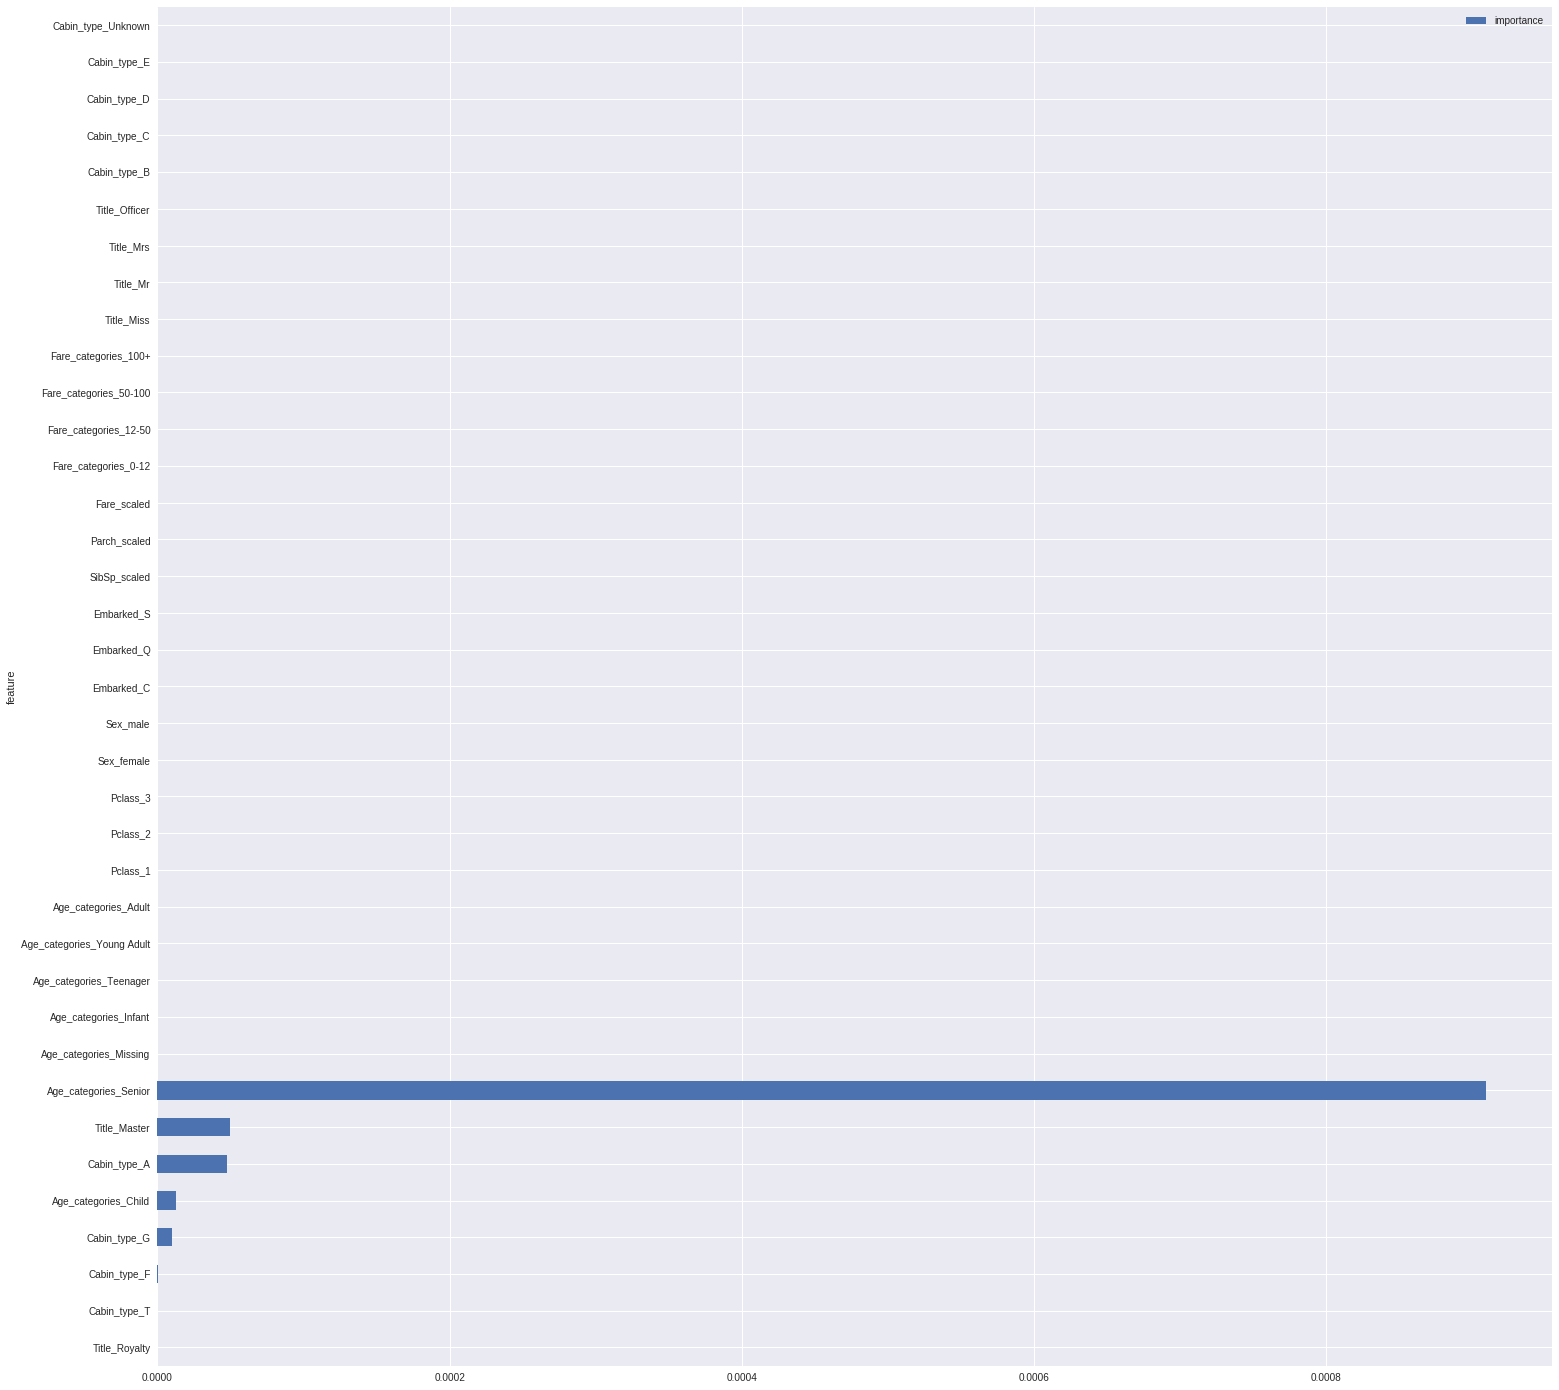

In [85]:
features = pd.DataFrame()
features['feature'] = X_mod.columns
features['importance'] = bdt_real.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(25, 25))


In [0]:

import numpy as np

from time import time
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits

import numpy as np
from Catboost import CatBoostClassifier

In [94]:
!pip install CatBoost

## 11.2 Tunning the AdaBoostClassifier with RandomizedSearchCV 




In [95]:

import numpy as np

from time import time
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits

import numpy as np
from catboost import CatBoostClassifier

# specify the training parameters 
#clf = AdaBoostClassifier(learning_rate=0.1, loss_function='Logloss', logging_level='Verbose')
clf = AdaBoostClassifier()

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

#AdaBoostClassifier(algorithm='SAMME.R',
#          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
#            max_features=None, max_leaf_nodes=None,
#            min_impurity_decrease=0.0, min_impurity_split=None,
#            min_samples_leaf=1, min_samples_split=2,
#            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
#            splitter='best'),
#          learning_rate=0.1, n_estimators=300, random_state=None)            

# specify parameters and distributions to sample from
param_dist = {#"iterations": sp_randint(15,50),
              #"max_depth" : sp_randint(5,16),
              "base_estimator" : [RandomForestClassifier(max_depth=10), RandomForestClassifier(max_depth=15) , DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=None, splitter='best') ],
             "learning_rate" : uniform(0.1, 1),
              "n_estimators" : sp_randint(10, 100),
               "algorithm" : ['SAMME', 'SAMME.R']}

# run randomized search 

#ValueError: Invalid parameter iterations for estimator AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
#          learning_rate=1.0, n_estimators=50, random_state=None). Check the list of available parameters with `estimator.get_params().keys()`.
  
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5)

start = time()
X_train, X_test, y_train, y_test = train_test_split(X_mod, y_mod, test_size=0.1, random_state=42)

random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)



RandomizedSearchCV took 89.31 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.816 (std: 0.028)
Parameters: {'algorithm': 'SAMME', 'base_estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), 'learning_rate': 0.8711340790902139, 'n_estimators': 72}

Model with rank: 2
Mean validation score: 0.813 (std: 0.026)
Parameters: {'algorithm': 'SAMME.R', 'base_estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
        

In [96]:
random_search.best_params_

{'algorithm': 'SAMME',
 'base_estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=10, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'learning_rate': 0.8711340790902139,
 'n_estimators': 72}

In [97]:
random_search

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
          fit_params=None, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'base_estimator': [RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,....stats._distn_infrastructure.rv_frozen object at 0x7faa93db2390>, 'algorithm': ['SAMME', 'SAMME.R']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [98]:
print(random_search.score(X_mod, y_mod))
print(random_search.score(X_train, y_train))
print(random_search.score(X_test, y_test))

0.9461279461279462
0.9575530586766542
0.8444444444444444


In [0]:
holdout_mod = pd.read_csv("holdout_modified.csv")

## 11.2 Tunning the AdaBoostClassifier with RandomizedSearchCV 
predictions = random_search.predict(holdout_mod.drop(["PassengerId"], axis = 1))

holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids, "Survived": predictions}
submission = pd.DataFrame(submission_df)
submission.to_csv("submission_AdaBoostClassifierRandomizedSearchCV0.csv",index=False)

**Score of 0.73684**

# 12 - Using the CatBoost: Score of 0.80382


Here we implements an Soluting using the CatBoost algorithm implementation.

CatBoost is a machine learning algorithm that uses gradient boosting on decision trees:

https://tech.yandex.com/catboost/doc/dg/concepts/python-quickstart-docpage/

## 12.1 - Installing the CatBoost

In [102]:
!pip install catboost


## 12.2 - Loading the modified data and executing the CatBoost

In [0]:
import pandas as pd

train_mod = pd.read_csv("train_modified.csv")
holdout_mod = pd.read_csv("holdout_modified.csv")
X_mod = train_mod.drop(["Survived","PassengerId"],axis=1)
y_mod = train_mod["Survived"]

In [105]:
import numpy as np
from catboost import CatBoostClassifier

# specify the training parameters 
model = CatBoostClassifier(iterations=46, depth=10, learning_rate=0.1, loss_function='Logloss', logging_level='Verbose')

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_mod, y_mod, test_size=0.3, random_state=42)

#train the model
#model.fit(X_train, y_train)

model.fit(X_mod, y_mod)

score_train = model.score(X_train, y_train)
print("Accuracy of Train Data", score_train)

score_test = model.score(X_test, y_test)
print("Accuracy of Test Data", score_test)

# make the prediction using the resulting model
predictions = model.predict(holdout_mod).astype(int)

print("class = ", predictions)

#preds_proba = model.predict_proba(test_data)
#print("proba = ", preds_proba)




0:	learn: 0.6265622	total: 153ms	remaining: 6.89s
1:	learn: 0.5910866	total: 171ms	remaining: 3.77s
2:	learn: 0.5649577	total: 189ms	remaining: 2.7s
3:	learn: 0.5313262	total: 206ms	remaining: 2.16s
4:	learn: 0.4995271	total: 227ms	remaining: 1.86s
5:	learn: 0.4776072	total: 252ms	remaining: 1.68s
6:	learn: 0.4566935	total: 302ms	remaining: 1.68s
7:	learn: 0.4460178	total: 322ms	remaining: 1.53s
8:	learn: 0.4351366	total: 343ms	remaining: 1.41s
9:	learn: 0.4232154	total: 426ms	remaining: 1.53s
10:	learn: 0.4179599	total: 445ms	remaining: 1.42s
11:	learn: 0.4128288	total: 463ms	remaining: 1.31s
12:	learn: 0.4043546	total: 559ms	remaining: 1.42s
13:	learn: 0.3969661	total: 612ms	remaining: 1.4s
14:	learn: 0.3918912	total: 645ms	remaining: 1.33s
15:	learn: 0.3861208	total: 725ms	remaining: 1.36s
16:	learn: 0.3845066	total: 746ms	remaining: 1.27s
17:	learn: 0.3799393	total: 768ms	remaining: 1.19s
18:	learn: 0.3792572	total: 782ms	remaining: 1.11s
19:	learn: 0.3762985	total: 816ms	remaining

In [0]:

holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids, "Survived": predictions}
submission = pd.DataFrame(submission_df)
submission.to_csv("submission_CatBoostClassifier_1.csv",index=False)


**Score of 0.80382**



![Rank on the Kaggle](https://drive.google.com/uc?export=view&id=1N8GM-_16JgWArc_-v9vc5nmghRKaplLw)




###  12.2.1 - Best result with CatBoostClassifier

`CatBoostClassifier(iterations=20, depth=10, learning_rate=0.1, loss_function='Logloss', logging_level='Verbose')`



## 12.3 - Using a Pool of CatBoost with Cross-validation

In [0]:
from catboost import Pool, cv

pool = Pool(X_mod, y_mod)

params = {'iterations': 100, 
          'depth': 3,        
          'loss_function': 'Logloss', 
          'verbose': False, 
          'roc_file': 'roc-file'}

scores = cv(pool,params)

In [109]:
scores


,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0.634429,0.001967,0.631455,0.007169
1,0.588940,0.004227,0.583346,0.012132
2,0.556678,0.006480,0.549612,0.016065
3,0.537791,0.008543,0.529330,0.019017
4,0.524288,0.011245,0.514679,0.019511
5,0.504129,0.014142,0.494408,0.021196
6,0.490563,0.015021,0.481200,0.019821
7,0.480098,0.016752,0.470309,0.020463
8,0.471156,0.021702,0.459900,0.018421
9,0.466393,0.023367,0.453930,0.018102


## 12.4 Tunning the CatBoost with RandomizedSearchCV: Bad Score of 0.74162


In [110]:
#from scipy.stats import randint as sp_randint

np.linspace(0,1.5,16)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5])

In [111]:

import numpy as np

from time import time
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits
#from sklearn.ensemble import RandomForestClassifier

import numpy as np
from catboost import CatBoostClassifier

# specify the training parameters 
clf = CatBoostClassifier(loss_function='Logloss', logging_level='Verbose')


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"iterations": sp_randint(15,50),
              "depth" : sp_randint(5,16),
              "learning_rate" : np.linspace(0,1,16)}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5)

start = time()
random_search.fit(X_mod, y_mod)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

# use a full grid over all parameters
param_grid =  {"iterations": sp_randint(15,50),
              "depth" : sp_randint(5,16),
              "learning_rate" : uniform(0,1)}

clf_grid = CatBoostClassifier(learning_rate=0.1, loss_function='Logloss', logging_level='Verbose')

# run grid search
#grid_search = GridSearchCV(clf_grid, param_grid=param_grid, cv=5)
#start = time()
#grid_search.fit(X_mod, y_mod)

#print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
#      % (time() - start, len(grid_search.cv_results_['params'])))
#report(grid_search.cv_results_)

0:	learn: 0.4705163	total: 27ms	remaining: 729ms
1:	learn: 0.4184352	total: 51.9ms	remaining: 675ms
2:	learn: 0.3978622	total: 70.3ms	remaining: 586ms
3:	learn: 0.3691248	total: 91.5ms	remaining: 549ms
4:	learn: 0.3633457	total: 112ms	remaining: 517ms
5:	learn: 0.3602342	total: 138ms	remaining: 506ms
6:	learn: 0.3561034	total: 163ms	remaining: 490ms
7:	learn: 0.3524464	total: 184ms	remaining: 461ms
8:	learn: 0.3492491	total: 210ms	remaining: 443ms
9:	learn: 0.3458739	total: 238ms	remaining: 428ms
10:	learn: 0.3416295	total: 264ms	remaining: 407ms
11:	learn: 0.3385310	total: 285ms	remaining: 380ms
12:	learn: 0.3323658	total: 304ms	remaining: 351ms
13:	learn: 0.3320759	total: 320ms	remaining: 320ms
14:	learn: 0.3252651	total: 341ms	remaining: 295ms
15:	learn: 0.3235418	total: 361ms	remaining: 271ms
16:	learn: 0.3187134	total: 379ms	remaining: 245ms
17:	learn: 0.3161134	total: 395ms	remaining: 219ms
18:	learn: 0.3158564	total: 414ms	remaining: 196ms
19:	learn: 0.3153201	total: 436ms	remai


Iteration with suspicious time 6.46 sec ignored in overall statistics.


14:	learn: 0.2906828	total: 644ms	remaining: 1.38s



Iteration with suspicious time 6.27 sec ignored in overall statistics.


15:	learn: 0.2857093	total: 644ms	remaining: 1.38s
16:	learn: 0.2825959	total: 907ms	remaining: 1.63s
17:	learn: 0.2804824	total: 1.17s	remaining: 1.9s
18:	learn: 0.2798367	total: 1.7s	remaining: 2.5s
19:	learn: 0.2661860	total: 7.29s	remaining: 9.72s
20:	learn: 0.2638688	total: 12.9s	remaining: 15.7s
21:	learn: 0.2609064	total: 18.5s	remaining: 20.4s
22:	learn: 0.2606971	total: 18.6s	remaining: 18.6s
23:	learn: 0.2597942	total: 19.9s	remaining: 18.1s
24:	learn: 0.2525576	total: 25.5s	remaining: 21.1s
25:	learn: 0.2439114	total: 31.4s	remaining: 23.6s
26:	learn: 0.2438388	total: 31.4s	remaining: 21.4s
27:	learn: 0.2249223	total: 37.4s	remaining: 23s
28:	learn: 0.2188847	total: 43s	remaining: 23.9s
29:	learn: 0.2161620	total: 48.9s	remaining: 24.4s
30:	learn: 0.2081838	total: 54.6s	remaining: 24.5s
31:	learn: 0.2074384	total: 1m	remaining: 24.1s
32:	learn: 0.2029539	total: 1m 5s	remaining: 23.4s
33:	learn: 0.2027377	total: 1m 5s	remaining: 20.6s
34:	learn: 0.2027156	total: 1m 5s	remaini


Iteration with suspicious time 6.48 sec ignored in overall statistics.


6:	learn: 0.3161130	total: 358ms	remaining: 2.26s
7:	learn: 0.3116979	total: 383ms	remaining: 1.97s
8:	learn: 0.3040476	total: 419ms	remaining: 1.83s
9:	learn: 0.2973276	total: 456ms	remaining: 1.72s
10:	learn: 0.2951384	total: 483ms	remaining: 1.59s
11:	learn: 0.2911882	total: 574ms	remaining: 1.67s
12:	learn: 0.2911409	total: 599ms	remaining: 1.55s
13:	learn: 0.2832580	total: 625ms	remaining: 1.44s
14:	learn: 0.2789310	total: 707ms	remaining: 1.47s
15:	learn: 0.2766734	total: 798ms	remaining: 1.49s



Iteration with suspicious time 5.82 sec ignored in overall statistics.


16:	learn: 0.2649953	total: 798ms	remaining: 1.49s
17:	learn: 0.2628322	total: 1.32s	remaining: 2.14s
18:	learn: 0.2579527	total: 7.17s	remaining: 10.6s
19:	learn: 0.2568213	total: 7.32s	remaining: 9.75s
20:	learn: 0.2518924	total: 8.62s	remaining: 10.4s
21:	learn: 0.2516079	total: 8.77s	remaining: 9.64s
22:	learn: 0.2513771	total: 14.3s	remaining: 14.3s
23:	learn: 0.2511605	total: 15.6s	remaining: 14.2s
24:	learn: 0.2460934	total: 21.3s	remaining: 17.6s
25:	learn: 0.2459378	total: 21.4s	remaining: 16.1s
26:	learn: 0.2337820	total: 27.1s	remaining: 18.4s
27:	learn: 0.2226390	total: 33.1s	remaining: 20.3s
28:	learn: 0.2102692	total: 38.9s	remaining: 21.6s
29:	learn: 0.2083876	total: 44.5s	remaining: 22.3s
30:	learn: 0.2079539	total: 47.4s	remaining: 21.2s
31:	learn: 0.2034097	total: 53s	remaining: 21.2s
32:	learn: 0.2024004	total: 58.6s	remaining: 20.8s
33:	learn: 0.1980877	total: 1m 4s	remaining: 20s
34:	learn: 0.1966390	total: 1m 9s	remaining: 19s
35:	learn: 0.1905867	total: 1m 15s	re


Iteration with suspicious time 4.14 sec ignored in overall statistics.


15:	learn: 0.3544595	total: 586ms	remaining: 899ms
16:	learn: 0.3495006	total: 652ms	remaining: 855ms
17:	learn: 0.3482558	total: 671ms	remaining: 789ms
18:	learn: 0.3461230	total: 691ms	remaining: 729ms
19:	learn: 0.3438613	total: 713ms	remaining: 676ms



Iteration with suspicious time 6.58 sec ignored in overall statistics.


20:	learn: 0.3365473	total: 713ms	remaining: 676ms
21:	learn: 0.3331056	total: 799ms	remaining: 639ms
22:	learn: 0.3316533	total: 825ms	remaining: 589ms
23:	learn: 0.3284515	total: 878ms	remaining: 559ms
24:	learn: 0.3264242	total: 909ms	remaining: 514ms
25:	learn: 0.3252035	total: 947ms	remaining: 473ms
26:	learn: 0.3249272	total: 964ms	remaining: 424ms
27:	learn: 0.3239054	total: 991ms	remaining: 381ms
28:	learn: 0.3226935	total: 1.04s	remaining: 348ms
29:	learn: 0.3219482	total: 1.07s	remaining: 306ms
30:	learn: 0.3178521	total: 1.38s	remaining: 333ms
31:	learn: 0.3169383	total: 1.41s	remaining: 281ms
32:	learn: 0.3158472	total: 1.43s	remaining: 231ms
33:	learn: 0.3114404	total: 1.49s	remaining: 186ms
34:	learn: 0.3104634	total: 1.52s	remaining: 138ms
35:	learn: 0.3094614	total: 1.54s	remaining: 90.6ms
36:	learn: 0.3047330	total: 1.62s	remaining: 46.4ms
37:	learn: 0.3033856	total: 1.71s	remaining: 0us
0:	learn: 0.6225290	total: 43.5ms	remaining: 1.61s
1:	learn: 0.5654142	total: 63.7


**The learning rate must be less than 1.**


In [112]:
print("Random_search best_score:", random_search.best_score_)
#print("Grid_search best_score:", grid_search.best_score_,"\n")

print("Random_search best_score:", random_search.best_params_)
#print("Grid_search best_score:", grid_search.best_params_,"\n")

Random_search best_score: 0.8316498316498316
Random_search best_score: {'depth': 15, 'iterations': 40, 'learning_rate': 0.9333333333333333}


In [0]:
predictions = random_search.predict(holdout_mod).astype(int)

holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids, "Survived": predictions}
submission = pd.DataFrame(submission_df)
submission.to_csv("submission_CatBoostClassifier_Random_Search.csv",index=False)


![alt text](https://drive.google.com/uc?export=view&id=1n7LSwZz7UIHOiXAxsVfitxCX6VNJSyMS)


**BAD! Overfit with: **

**Random_search best_score: {'depth': 10, 'iterations': 46, 'learning_rate': 0.5} **

# 13 - Appling the Voting strategy for Ensemble

In [0]:
import pandas as pd

train_mod = pd.read_csv("train_modified.csv")
holdout_mod = pd.read_csv("holdout_modified.csv")
X_mod = train_mod.drop(["Survived","PassengerId"],axis=1)
y_mod = train_mod["Survived"]

In [116]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from sklearn.metrics import make_scorer, roc_auc_score
from scipy import stats

auc = make_scorer(roc_auc_score)
rand_list = {"C": stats.uniform(2, 10),
                        "gamma": stats.uniform(0.1, 1)}


# X_train0, X_test0, y_train0, y_test0 = train_test_split(X_mod, y_mod, test_size=0.1, random_state=42)
#X = train[0::, 1::]
#y = train[0::, 0]
X = X_mod
y = y_mod
clf = SVC()


rand_search = RandomizedSearchCV(clf, param_distributions = rand_list, n_iter = 20, n_jobs = 4, cv = 3, random_state = 2017, scoring = auc) 
rand_search.fit(X,y)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=4,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7faa949656d8>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7faa949654a8>},
          pre_dispatch='2*n_jobs', random_state=2017, refit=True,
          return_train_score='warn', scoring=make_scorer(roc_auc_score),
          verbose=0)

In [117]:
rand_search.best_estimator_

SVC(C=9.062264858625882, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.5565289675398223,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0:	learn: 0.6566896	total: 66.9ms	remaining: 1.27s
1:	learn: 0.6025596	total: 113ms	remaining: 1.02s
2:	learn: 0.5513138	total: 294ms	remaining: 1.67s
3:	learn: 0.5126495	total: 389ms	remaining: 1.56s
4:	learn: 0.4858538	total: 419ms	remaining: 1.26s
5:	learn: 0.4630220	total: 514ms	remaining: 1.2s
6:	learn: 0.4412954	total: 564ms	remaining: 1.05s
7:	learn: 0.4304708	total: 616ms	remaining: 924ms
8:	learn: 0.4232013	total: 649ms	remaining: 794ms
9:	learn: 0.4087937	total: 779ms	remaining: 779ms
10:	learn: 0.4014701	total: 830ms	remaining: 679ms
11:	learn: 0.3947662	total: 891ms	remaining: 594ms
12:	learn: 0.3897094	total: 1.03s	remaining: 553ms
13:	learn: 0.3826334	total: 1.16s	remaining: 496ms
14:	learn: 0.3775345	total: 1.25s	remaining: 416ms
15:	learn: 0.3709895	total: 1.38s	remaining: 344ms
16:	learn: 0.3675606	total: 1.51s	remaining: 267ms
17:	learn: 0.3653313	total: 1.55s	remaining: 172ms
18:	learn: 0.3634179	total: 1.59s	remaining: 83.6ms
19:	learn: 0.3609883	total: 1.62s	remain

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0:	learn: 0.6557563	total: 52.4ms	remaining: 996ms
1:	learn: 0.6023802	total: 109ms	remaining: 983ms
2:	learn: 0.5517437	total: 288ms	remaining: 1.63s
3:	learn: 0.5176983	total: 382ms	remaining: 1.53s
4:	learn: 0.4885064	total: 418ms	remaining: 1.25s
5:	learn: 0.4684127	total: 551ms	remaining: 1.28s
6:	learn: 0.4533389	total: 603ms	remaining: 1.12s
7:	learn: 0.4386071	total: 654ms	remaining: 981ms
8:	learn: 0.4345407	total: 682ms	remaining: 833ms
9:	learn: 0.4267429	total: 711ms	remaining: 711ms
10:	learn: 0.4159189	total: 762ms	remaining: 623ms
11:	learn: 0.4074074	total: 790ms	remaining: 527ms
12:	learn: 0.4014224	total: 876ms	remaining: 472ms
13:	learn: 0.3960829	total: 909ms	remaining: 389ms
14:	learn: 0.3895834	total: 996ms	remaining: 332ms
15:	learn: 0.3845892	total: 1.08s	remaining: 270ms
16:	learn: 0.3773298	total: 1.24s	remaining: 219ms
17:	learn: 0.3736188	total: 1.32s	remaining: 147ms
18:	learn: 0.3688896	total: 1.39s	remaining: 72.9ms
19:	learn: 0.3647657	total: 1.51s	remai

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0:	learn: 0.6249845	total: 62.8ms	remaining: 1.19s
1:	learn: 0.5760136	total: 190ms	remaining: 1.71s
2:	learn: 0.5423459	total: 220ms	remaining: 1.25s
3:	learn: 0.5113834	total: 249ms	remaining: 995ms
4:	learn: 0.4846644	total: 284ms	remaining: 853ms
5:	learn: 0.4629314	total: 370ms	remaining: 862ms
6:	learn: 0.4446942	total: 515ms	remaining: 957ms
7:	learn: 0.4321501	total: 553ms	remaining: 830ms
8:	learn: 0.4191557	total: 681ms	remaining: 832ms
9:	learn: 0.4084963	total: 738ms	remaining: 738ms
10:	learn: 0.4028870	total: 768ms	remaining: 628ms
11:	learn: 0.3935080	total: 899ms	remaining: 599ms
12:	learn: 0.3901659	total: 952ms	remaining: 513ms
13:	learn: 0.3849084	total: 981ms	remaining: 421ms
14:	learn: 0.3840940	total: 1s	remaining: 335ms
15:	learn: 0.3822197	total: 1.03s	remaining: 259ms
16:	learn: 0.3810676	total: 1.06s	remaining: 187ms
17:	learn: 0.3771732	total: 1.12s	remaining: 124ms
18:	learn: 0.3745152	total: 1.15s	remaining: 60.4ms
19:	learn: 0.3694840	total: 1.2s	remaining

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0:	learn: 0.6555863	total: 51.5ms	remaining: 978ms
1:	learn: 0.6211814	total: 85.8ms	remaining: 772ms
2:	learn: 0.5711587	total: 218ms	remaining: 1.23s
3:	learn: 0.5297790	total: 349ms	remaining: 1.4s
4:	learn: 0.5034178	total: 376ms	remaining: 1.13s
5:	learn: 0.4860274	total: 417ms	remaining: 973ms
6:	learn: 0.4673944	total: 446ms	remaining: 829ms
7:	learn: 0.4615852	total: 469ms	remaining: 704ms
8:	learn: 0.4472128	total: 498ms	remaining: 609ms
9:	learn: 0.4291668	total: 641ms	remaining: 641ms
10:	learn: 0.4183306	total: 668ms	remaining: 546ms
11:	learn: 0.4113620	total: 710ms	remaining: 473ms
12:	learn: 0.4008756	total: 853ms	remaining: 459ms
13:	learn: 0.3991471	total: 875ms	remaining: 375ms
14:	learn: 0.3919619	total: 914ms	remaining: 305ms
15:	learn: 0.3844342	total: 1.04s	remaining: 261ms
16:	learn: 0.3807838	total: 1.08s	remaining: 191ms
17:	learn: 0.3767258	total: 1.14s	remaining: 127ms
18:	learn: 0.3708140	total: 1.23s	remaining: 64.5ms
19:	learn: 0.3703448	total: 1.25s	remai

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0:	learn: 0.6569320	total: 57.2ms	remaining: 1.09s
1:	learn: 0.6027354	total: 103ms	remaining: 928ms
2:	learn: 0.5635311	total: 273ms	remaining: 1.54s
3:	learn: 0.5356424	total: 297ms	remaining: 1.19s
4:	learn: 0.5100445	total: 319ms	remaining: 958ms
5:	learn: 0.4868497	total: 450ms	remaining: 1.05s
6:	learn: 0.4725387	total: 487ms	remaining: 905ms
7:	learn: 0.4556999	total: 609ms	remaining: 914ms
8:	learn: 0.4421225	total: 645ms	remaining: 788ms
9:	learn: 0.4362664	total: 673ms	remaining: 673ms
10:	learn: 0.4297040	total: 703ms	remaining: 575ms
11:	learn: 0.4166280	total: 761ms	remaining: 507ms
12:	learn: 0.4076631	total: 809ms	remaining: 436ms
13:	learn: 0.4027302	total: 942ms	remaining: 404ms
14:	learn: 0.4014893	total: 970ms	remaining: 323ms
15:	learn: 0.3992109	total: 995ms	remaining: 249ms
16:	learn: 0.3960305	total: 1.03s	remaining: 182ms
17:	learn: 0.3927077	total: 1.07s	remaining: 118ms
18:	learn: 0.3909623	total: 1.09s	remaining: 57.4ms
19:	learn: 0.3887707	total: 1.12s	remai

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0:	learn: 0.6585613	total: 49.4ms	remaining: 939ms
1:	learn: 0.6111266	total: 94.7ms	remaining: 852ms
2:	learn: 0.5716126	total: 118ms	remaining: 670ms
3:	learn: 0.5348787	total: 219ms	remaining: 877ms
4:	learn: 0.5114547	total: 358ms	remaining: 1.07s
5:	learn: 0.4892320	total: 442ms	remaining: 1.03s
6:	learn: 0.4723504	total: 535ms	remaining: 993ms
7:	learn: 0.4565481	total: 568ms	remaining: 852ms
8:	learn: 0.4417070	total: 604ms	remaining: 738ms
9:	learn: 0.4342025	total: 631ms	remaining: 631ms
10:	learn: 0.4233702	total: 770ms	remaining: 630ms
11:	learn: 0.4160180	total: 816ms	remaining: 544ms
12:	learn: 0.4104513	total: 847ms	remaining: 456ms
13:	learn: 0.4028731	total: 885ms	remaining: 379ms
14:	learn: 0.3945372	total: 1.02s	remaining: 339ms
15:	learn: 0.3894726	total: 1.05s	remaining: 263ms
16:	learn: 0.3852065	total: 1.08s	remaining: 191ms
17:	learn: 0.3822686	total: 1.12s	remaining: 125ms
18:	learn: 0.3813115	total: 1.15s	remaining: 60.3ms
19:	learn: 0.3743687	total: 1.29s	rema

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0:	learn: 0.6587747	total: 41.7ms	remaining: 793ms
1:	learn: 0.6078561	total: 100ms	remaining: 900ms
2:	learn: 0.5610286	total: 260ms	remaining: 1.48s
3:	learn: 0.5407792	total: 284ms	remaining: 1.14s
4:	learn: 0.5114835	total: 315ms	remaining: 944ms
5:	learn: 0.4910324	total: 344ms	remaining: 802ms
6:	learn: 0.4820088	total: 371ms	remaining: 689ms
7:	learn: 0.4652440	total: 431ms	remaining: 646ms
8:	learn: 0.4526007	total: 484ms	remaining: 591ms
9:	learn: 0.4394921	total: 569ms	remaining: 569ms
10:	learn: 0.4248839	total: 725ms	remaining: 593ms
11:	learn: 0.4215309	total: 754ms	remaining: 503ms
12:	learn: 0.4105981	total: 898ms	remaining: 484ms
13:	learn: 0.4023446	total: 1.03s	remaining: 442ms
14:	learn: 0.3991032	total: 1.06s	remaining: 355ms
15:	learn: 0.3943414	total: 1.1s	remaining: 275ms
16:	learn: 0.3910099	total: 1.13s	remaining: 200ms
17:	learn: 0.3875174	total: 1.16s	remaining: 129ms
18:	learn: 0.3857810	total: 1.19s	remaining: 62.7ms
19:	learn: 0.3836602	total: 1.22s	remain

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0:	learn: 0.6301737	total: 73.4ms	remaining: 1.39s
1:	learn: 0.5904870	total: 123ms	remaining: 1.11s
2:	learn: 0.5678494	total: 150ms	remaining: 851ms
3:	learn: 0.5265967	total: 300ms	remaining: 1.2s
4:	learn: 0.5043745	total: 329ms	remaining: 986ms
5:	learn: 0.4827990	total: 364ms	remaining: 849ms
6:	learn: 0.4585703	total: 455ms	remaining: 845ms
7:	learn: 0.4409994	total: 584ms	remaining: 875ms
8:	learn: 0.4306726	total: 613ms	remaining: 749ms
9:	learn: 0.4233426	total: 744ms	remaining: 744ms
10:	learn: 0.4122293	total: 882ms	remaining: 722ms
11:	learn: 0.4045406	total: 918ms	remaining: 612ms
12:	learn: 0.3949959	total: 1.01s	remaining: 544ms
13:	learn: 0.3908682	total: 1.06s	remaining: 456ms
14:	learn: 0.3859552	total: 1.15s	remaining: 384ms
15:	learn: 0.3847268	total: 1.18s	remaining: 295ms
16:	learn: 0.3831017	total: 1.21s	remaining: 213ms
17:	learn: 0.3782321	total: 1.3s	remaining: 145ms
18:	learn: 0.3764913	total: 1.33s	remaining: 70.1ms
19:	learn: 0.3696872	total: 1.47s	remaini

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0:	learn: 0.6544301	total: 58.4ms	remaining: 1.11s
1:	learn: 0.5992992	total: 98.5ms	remaining: 886ms
2:	learn: 0.5495392	total: 239ms	remaining: 1.35s
3:	learn: 0.5169798	total: 331ms	remaining: 1.32s
4:	learn: 0.4867281	total: 366ms	remaining: 1.1s
5:	learn: 0.4691696	total: 394ms	remaining: 919ms
6:	learn: 0.4499000	total: 476ms	remaining: 884ms
7:	learn: 0.4419143	total: 499ms	remaining: 748ms
8:	learn: 0.4249885	total: 592ms	remaining: 724ms
9:	learn: 0.4163832	total: 674ms	remaining: 674ms
10:	learn: 0.4093748	total: 697ms	remaining: 570ms
11:	learn: 0.4013614	total: 727ms	remaining: 485ms
12:	learn: 0.3974018	total: 749ms	remaining: 404ms
13:	learn: 0.3916690	total: 810ms	remaining: 347ms
14:	learn: 0.3886649	total: 834ms	remaining: 278ms
15:	learn: 0.3842539	total: 869ms	remaining: 217ms
16:	learn: 0.3811629	total: 907ms	remaining: 160ms
17:	learn: 0.3791356	total: 942ms	remaining: 105ms
18:	learn: 0.3754187	total: 1.08s	remaining: 56.7ms
19:	learn: 0.3728045	total: 1.16s	remai

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0:	learn: 0.6309873	total: 67.1ms	remaining: 1.27s
1:	learn: 0.5852585	total: 102ms	remaining: 916ms
2:	learn: 0.5597275	total: 135ms	remaining: 765ms
3:	learn: 0.5341166	total: 164ms	remaining: 656ms
4:	learn: 0.5159757	total: 186ms	remaining: 557ms
5:	learn: 0.4997194	total: 220ms	remaining: 514ms
6:	learn: 0.4800166	total: 256ms	remaining: 475ms
7:	learn: 0.4591017	total: 375ms	remaining: 563ms
8:	learn: 0.4496086	total: 417ms	remaining: 510ms
9:	learn: 0.4388054	total: 446ms	remaining: 446ms
10:	learn: 0.4293602	total: 576ms	remaining: 471ms
11:	learn: 0.4266146	total: 603ms	remaining: 402ms
12:	learn: 0.4227843	total: 632ms	remaining: 340ms
13:	learn: 0.4188839	total: 692ms	remaining: 297ms
14:	learn: 0.4132647	total: 794ms	remaining: 265ms
15:	learn: 0.4088354	total: 895ms	remaining: 224ms
16:	learn: 0.4020614	total: 946ms	remaining: 167ms
17:	learn: 0.4008398	total: 977ms	remaining: 109ms
18:	learn: 0.3961011	total: 1.01s	remaining: 53.3ms
19:	learn: 0.3942689	total: 1.04s	remai

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


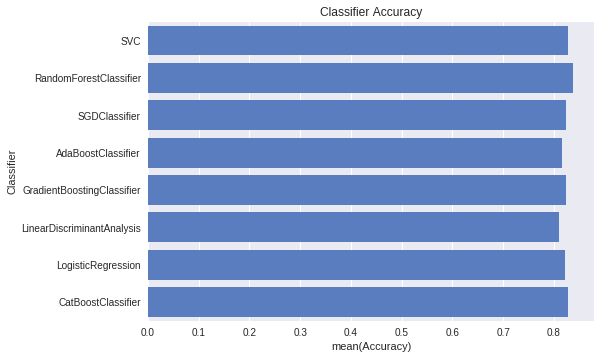

In [118]:
  
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from catboost import CatBoostClassifier


from sklearn.model_selection import train_test_split

X_train0, X_test0, y_train0, y_test0 = train_test_split(X_mod, y_mod, test_size=0.1, random_state=42)

 #{'AdaBoostClassifier': 0.7950617283950618,
 #'CatBoostClassifier': 0.8185185185185185,
 #'DecisionTreeClassifier': 0.774074074074074,
 #'GaussianNB': 0.7358024691358025,
 #'GradientBoostingClassifier': 0.8160493827160493,
 #'KNeighborsClassifier': 0.7777777777777777,
 #'LinearDiscriminantAnalysis': 0.8135802469135802,
 #'LogisticRegression': 0.8209876543209876,
 #'RandomForestClassifier': 0.8246913580246913,
 #'SGDClassifier': 0.8185185185185185,
 #'SVC': 0.8160493827160493}

  
 #{'algorithm': 'SAMME',
 # 'base_estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
 #            max_depth=10, max_features='auto', max_leaf_nodes=None,
  #           min_impurity_decrease=0.0, min_impurity_split=None,
   #          min_samples_leaf=1, min_samples_split=2,
   #          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
    #         oob_score=False, random_state=None, verbose=0,
     #        warm_start=False),
 #'learning_rate': 0.802656626129159,
 #'n_estimators': 36} 


classifiers = [
    #KNeighborsClassifier(algorithm='brute', n_neighbors= 3, p= 1, weights='uniform'),
    #SVC(probability=True, C= 1, gamma = 0.1, kernel= 'rbf'),
    SVC(C=9.062264858625882, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.5565289675398223, kernel='rbf', max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001, verbose=False),
    #DecisionTreeClassifier(),
    RandomForestClassifier(criterion= 'gini', max_depth=10, max_features= 'log2', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 200),
    SGDClassifier(alpha= 0.001, l1_ratio= 0.8, learning_rate='optimal', loss='log', max_iter= 1000, penalty= 'elasticnet', shuffle= True),
 	  AdaBoostClassifier(RandomForestClassifier(max_depth=10,  criterion='gini', min_samples_leaf=1, min_samples_split=2), n_estimators=36, learning_rate=0.802656626129159, algorithm="SAMME"),
    GradientBoostingClassifier(),
    #GaussianNB(),
    LinearDiscriminantAnalysis(),
    #QuadraticDiscriminantAnalysis(),
    LogisticRegression(solver='newton-cg'),
    CatBoostClassifier(iterations=20, depth=10, learning_rate=0.1, loss_function='Logloss', logging_level='Verbose')]

log_cols = ["Classifier", "Accuracy"]
log 	 = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = X_mod
y = y_mod

acc_dict = {}

for train_index, test_index in sss.split(X_mod, y_mod):
	X_train, X_test = X.iloc[train_index], X.iloc[test_index]
	y_train, y_test = y.iloc[train_index], y.iloc[test_index]
	
	for clf in classifiers:
		name = clf.__class__.__name__
		clf.fit(X_train, y_train)
		train_predictions = clf.predict(X_test)
		acc = accuracy_score(y_test, train_predictions)
		if name in acc_dict:
			acc_dict[name] += acc
		else:
			acc_dict[name] = acc

for clf in acc_dict:
	acc_dict[clf] = acc_dict[clf] / 10.0
	log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
	log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

In [119]:
 acc_dict
  

{'AdaBoostClassifier': 0.8166666666666667,
 'CatBoostClassifier': 0.8277777777777778,
 'GradientBoostingClassifier': 0.8244444444444443,
 'LinearDiscriminantAnalysis': 0.8099999999999999,
 'LogisticRegression': 0.821111111111111,
 'RandomForestClassifier': 0.8377777777777776,
 'SGDClassifier': 0.8233333333333333,
 'SVC': 0.8277777777777777}

In [120]:
classifiers

[SVC(C=9.062264858625882, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma=0.5565289675398223,
   kernel='rbf', max_iter=-1, probability=True, random_state=None,
   shrinking=True, tol=0.001, verbose=False),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=10, max_features='log2', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
        eta0=0.0, fit_intercept=True, l1_ratio=0.8, learning_rate='optimal',
        loss='log', max_iter=1000, n_iter=None, n_jobs=1,
        penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
        tol=None, verbose=0, wa

In [121]:
predictions = []

for clf in classifiers:
  predictions.append(clf.predict_proba(X_train0)[:,1])
    
combined = np.sum(predictions, axis=0) / len(classifiers)     
rounded = np.round(combined)
 
acc = accuracy_score(y_train0, rounded)
print("Predictions of X_train", acc)

Predictions of X_train 0.8789013732833958


In [122]:
predictions = []

for clf in classifiers:
  predictions.append(clf.predict_proba(X_test0)[:,1])
    
combined = np.sum(predictions, axis=0) / len(classifiers)     
rounded = np.round(combined)
 
acc = accuracy_score(y_test0, rounded)
print("Predictions of X_test", acc)

Predictions of X_test 0.9


In [0]:
import pandas as pd

test = pd.read_csv("test.csv")

hold = holdout_mod.drop(["PassengerId"],axis=1)

predictions = []

for clf in classifiers:
  predictions.append(clf.predict_proba(hold)[:,1])
    
combined = np.sum(predictions, axis=0) / len(classifiers)     
rounded = np.round(combined).astype(int)
 
holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids, "Survived": rounded}
submission = pd.DataFrame(submission_df)
submission.to_csv("submission_Ensemble_Voting2.csv",index=False)

**Score of 0.78947**

# 14 - VotingClassifier from Sklearn: Bad Score of 0.77990

In [124]:
from sklearn.ensemble import VotingClassifier

classifiers = [
    #KNeighborsClassifier(algorithm='brute', n_neighbors= 3, p= 1, weights='uniform'),
    #SVC(probability=True, C= 1, gamma = 0.1, kernel= 'rbf'),
    ('svm', SVC(C=9.062264858625882, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.5565289675398223, kernel='rbf', max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001, verbose=False)),
    #(DecisionTreeClassifier(),
    ('rf', RandomForestClassifier(criterion= 'gini', max_depth=10, max_features= 'log2', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 200)),
    ('sg',SGDClassifier(alpha= 0.001, l1_ratio= 0.8, learning_rate='optimal', loss='log', max_iter= 1000, penalty= 'elasticnet', shuffle= True)),
 	  #AdaBoostClassifier(RandomForestClassifier(max_depth=15), n_estimators=200, learning_rate=0.1, algorithm="SAMME"),
    ('gb',GradientBoostingClassifier()),
    #GaussianNB()),
    ('ld', LinearDiscriminantAnalysis()),
    #QuadraticDiscriminantAnalysis()),
    ('logr', LogisticRegression(solver='newton-cg')),
    ('catb', CatBoostClassifier(iterations=20, depth=10, learning_rate=0.1, loss_function='Logloss', logging_level='Verbose'))]


eclf1 = VotingClassifier(classifiers, voting='soft', flatten_transform=True)


eclf1 = eclf1.fit(X_mod, y_mod)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0:	learn: 0.6265622	total: 181ms	remaining: 3.44s
1:	learn: 0.5910866	total: 207ms	remaining: 1.86s
2:	learn: 0.5649577	total: 227ms	remaining: 1.28s
3:	learn: 0.5313262	total: 251ms	remaining: 1s
4:	learn: 0.4995271	total: 276ms	remaining: 827ms
5:	learn: 0.4776072	total: 306ms	remaining: 715ms
6:	learn: 0.4566935	total: 390ms	remaining: 724ms
7:	learn: 0.4460178	total: 419ms	remaining: 628ms
8:	learn: 0.4351366	total: 448ms	remaining: 548ms
9:	learn: 0.4232154	total: 571ms	remaining: 571ms
10:	learn: 0.4179599	total: 599ms	remaining: 490ms
11:	learn: 0.4128288	total: 625ms	remaining: 417ms
12:	learn: 0.4043546	total: 741ms	remaining: 399ms
13:	learn: 0.3969661	total: 829ms	remaining: 355ms
14:	learn: 0.3918912	total: 876ms	remaining: 292ms
15:	learn: 0.3861208	total: 993ms	remaining: 248ms
16:	learn: 0.3845066	total: 1.01s	remaining: 179ms
17:	learn: 0.3799393	total: 1.04s	remaining: 116ms
18:	learn: 0.3792572	total: 1.06s	remaining: 55.7ms
19:	learn: 0.3762985	total: 1.11s	remaining

In [125]:
eclf1

VotingClassifier(estimators=[('svm', SVC(C=9.062264858625882, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.5565289675398223,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)), ('rf', RandomForestClassifie...erbose=0, warm_start=False)), ('catb', <catboost.core.CatBoostClassifier object at 0x7faa93c7b1d0>)],
         flatten_transform=True, n_jobs=1, voting='soft', weights=None)

In [126]:
print(eclf1.score(X_mod, y_mod))

0.8821548821548821


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [127]:
hold = holdout_mod.drop(["PassengerId"],axis=1)

predictions = eclf1.predict(hold)
 
holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids, "Survived": predictions}
submission = pd.DataFrame(submission_df)
submission.to_csv("submission_VotingClassifier0.csv",index=False)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


![alt text](https://drive.google.com/uc?export=view&id=1CpmCiebxXoQ-_B1eqNa9-GhYG2hqhUoe)


# 15 - New Pre-processing with VotingClassifier from Sklearn: Bad Score of 0.77990

In [128]:
import numpy as np
import pandas as pd
import re as re

train = pd.read_csv('train.csv', header=0, dtype={'Age': np.float64})
test = pd.read_csv('test.csv', header=0, dtype={'Age': np.float64})
full_data = [train, test]

### PRE-PROCESSING

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    dataset['Title'] = dataset['Name'].apply(get_title)
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', \
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male': 1}).astype(int)

    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

    # Mapping Fare
    dataset.loc[dataset['Fare'] <= 10, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 10) & (dataset['Fare'] <= 20), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 20) & (dataset['Fare'] <= 30), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 30, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    # Mapping Age
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4

train['CategoricalFare'] = pd.cut(train['Fare'], 4)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

# Feature Selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp',\
                 'Parch', 'FamilySize']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test = test.drop(drop_elements, axis = 1)
#train = train.values
#test = test.values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [129]:
from sklearn.ensemble import VotingClassifier

classifiers = [
    #KNeighborsClassifier(algorithm='brute', n_neighbors= 3, p= 1, weights='uniform'),
    #SVC(probability=True, C= 1, gamma = 0.1, kernel= 'rbf'),
    ('svm', SVC(C=9.062264858625882, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.5565289675398223, kernel='rbf', max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001, verbose=False)),
    #(DecisionTreeClassifier(),
    ('rf', RandomForestClassifier(criterion= 'gini', max_depth=10, max_features= 'log2', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 200)),
    ('sg',SGDClassifier(alpha= 0.001, l1_ratio= 0.8, learning_rate='optimal', loss='log', max_iter= 1000, penalty= 'elasticnet', shuffle= True)),
 	  #AdaBoostClassifier(RandomForestClassifier(max_depth=15), n_estimators=200, learning_rate=0.1, algorithm="SAMME"),
    ('gb',GradientBoostingClassifier()),
    #GaussianNB()),
    ('ld', LinearDiscriminantAnalysis()),
    #QuadraticDiscriminantAnalysis()),
    ('logr', LogisticRegression(solver='newton-cg')),
    ('catb', CatBoostClassifier(iterations=20, depth=10, learning_rate=0.1, loss_function='Logloss', logging_level='Verbose'))]


eclf1 = VotingClassifier(classifiers, voting='soft', flatten_transform=True)


from sklearn.model_selection import train_test_split

#X_train0, X_test0, y_train0, y_test0 = train_test_split(X_mod, y_mod, test_size=0.1, random_state=42)

eclf1 = eclf1.fit(train.drop(["Survived"], axis=1), train["Survived"])

0:	learn: 0.6232414	total: 59.6ms	remaining: 1.13s
1:	learn: 0.5702045	total: 98.2ms	remaining: 884ms
2:	learn: 0.5385890	total: 120ms	remaining: 680ms
3:	learn: 0.5226439	total: 136ms	remaining: 545ms
4:	learn: 0.5030239	total: 157ms	remaining: 471ms
5:	learn: 0.4804613	total: 187ms	remaining: 435ms
6:	learn: 0.4584624	total: 212ms	remaining: 393ms
7:	learn: 0.4454996	total: 235ms	remaining: 353ms
8:	learn: 0.4396757	total: 253ms	remaining: 309ms
9:	learn: 0.4350755	total: 275ms	remaining: 275ms
10:	learn: 0.4322297	total: 295ms	remaining: 242ms
11:	learn: 0.4196232	total: 328ms	remaining: 219ms
12:	learn: 0.4149617	total: 346ms	remaining: 186ms
13:	learn: 0.4098731	total: 364ms	remaining: 156ms
14:	learn: 0.4075052	total: 385ms	remaining: 128ms
15:	learn: 0.4033770	total: 409ms	remaining: 102ms
16:	learn: 0.3987303	total: 427ms	remaining: 75.3ms
17:	learn: 0.3960919	total: 444ms	remaining: 49.4ms
18:	learn: 0.3943157	total: 463ms	remaining: 24.4ms
19:	learn: 0.3937952	total: 484ms	re

In [130]:
print(eclf1.score(train.drop(["Survived"], axis=1), train["Survived"]))

0.8529741863075196


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [131]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from catboost import CatBoostClassifier


from sklearn.model_selection import train_test_split

#X_train0, X_test0, y_train0, y_test0 = train_test_split(train.drop(["Survived"], axis=1), train["Survived"], test_size=0.1, random_state=42)

#{'CatBoostClassifier': 0.8233333333333335,
# 'GradientBoostingClassifier': 0.8188888888888888,
# 'LinearDiscriminantAnalysis': 0.7933333333333332,
# 'LogisticRegression': 0.7944444444444443,
# 'RandomForestClassifier': 0.8088888888888889,
# 'SGDClassifier': 0.7944444444444444,
# 'SVC': 0.8122222222222222}

classifiers = [
    #KNeighborsClassifier(algorithm='brute', n_neighbors= 3, p= 1, weights='uniform'),
    #SVC(probability=True, C= 1, gamma = 0.1, kernel= 'rbf'),
    SVC(C=9.062264858625882, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.5565289675398223, kernel='rbf', max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001, verbose=False),
    #DecisionTreeClassifier(),
    RandomForestClassifier(criterion= 'gini', max_depth=10, max_features= 'log2', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 200),
    #SGDClassifier(alpha= 0.001, l1_ratio= 0.8, learning_rate='optimal', loss='log', max_iter= 1000, penalty= 'elasticnet', shuffle= True),
 	  AdaBoostClassifier(RandomForestClassifier(max_depth=10), n_estimators=48, learning_rate=1.0888, algorithm="SAMME.R"),
    GradientBoostingClassifier(),
    #GaussianNB(),
    #LinearDiscriminantAnalysis(),
    #QuadraticDiscriminantAnalysis(),
    #LogisticRegression(solver='newton-cg'),
    CatBoostClassifier(iterations=20, depth=10, learning_rate=0.1, loss_function='Logloss', logging_level='Verbose')]

log_cols = ["Classifier", "Accuracy"]
log 	 = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = train.drop(["Survived"], axis=1)
y = train["Survived"]

acc_dict = {}

for train_index, test_index in sss.split(X, y):
	X_train, X_test = X.iloc[train_index], X.iloc[test_index]
	y_train, y_test = y.iloc[train_index], y.iloc[test_index]
	
	for clf in classifiers:
		name = clf.__class__.__name__
		clf.fit(X_train, y_train)
		train_predictions = clf.predict(X_test)
		acc = accuracy_score(y_test, train_predictions)
		if name in acc_dict:
			acc_dict[name] += acc
		else:
			acc_dict[name] = acc

for clf in acc_dict:
	acc_dict[clf] = acc_dict[clf] / 10.0
	log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
	log = log.append(log_entry)


0:	learn: 0.6313683	total: 28.4ms	remaining: 539ms
1:	learn: 0.5876303	total: 56.7ms	remaining: 510ms
2:	learn: 0.5604465	total: 84.3ms	remaining: 478ms
3:	learn: 0.5291858	total: 111ms	remaining: 444ms
4:	learn: 0.5100743	total: 137ms	remaining: 412ms
5:	learn: 0.4908572	total: 164ms	remaining: 382ms
6:	learn: 0.4676569	total: 199ms	remaining: 369ms
7:	learn: 0.4511088	total: 232ms	remaining: 348ms
8:	learn: 0.4465700	total: 259ms	remaining: 316ms
9:	learn: 0.4305278	total: 288ms	remaining: 288ms
10:	learn: 0.4234062	total: 317ms	remaining: 259ms
11:	learn: 0.4192601	total: 337ms	remaining: 225ms
12:	learn: 0.4123513	total: 365ms	remaining: 197ms
13:	learn: 0.4110156	total: 389ms	remaining: 167ms
14:	learn: 0.4099418	total: 413ms	remaining: 138ms
15:	learn: 0.4065740	total: 443ms	remaining: 111ms
16:	learn: 0.4058851	total: 466ms	remaining: 82.3ms
17:	learn: 0.4037167	total: 492ms	remaining: 54.7ms
18:	learn: 0.4008564	total: 519ms	remaining: 27.3ms
19:	learn: 0.4001617	total: 540ms	r

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


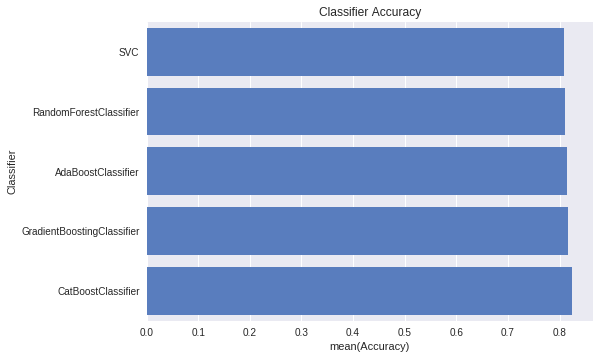

In [132]:
plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

In [133]:
predictions = []

for clf in classifiers:
  predictions.append(clf.predict_proba(X)[:,1])
    
combined = np.sum(predictions, axis=0) / len(classifiers)     
rounded = np.round(combined)
 
acc = accuracy_score(y, rounded)
print("Predictions of X_train", acc)

Predictions of X_train 0.8664421997755332


In [134]:
acc_dict

{'AdaBoostClassifier': 0.8144444444444445,
 'CatBoostClassifier': 0.8233333333333335,
 'GradientBoostingClassifier': 0.8166666666666667,
 'RandomForestClassifier': 0.8111111111111111,
 'SVC': 0.8077777777777777}

In [0]:
import pandas as pd


hold = test

predictions = []

for clf in classifiers:
  predictions.append(clf.predict_proba(hold)[:,1])
    
combined = np.sum(predictions, axis=0) / len(classifiers)     
rounded = np.round(combined).astype(int)
 
holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids, "Survived": rounded}
submission = pd.DataFrame(submission_df)
submission.to_csv("submission_Ensemble_Voting0_section15.csv",index=False)

![alt text](https://drive.google.com/uc?export=view&id=1jUT65euStJbzpF7eKdTHUzRcI_OyphxU)


# 16 -  Another Preprocessing Try-all with KNN: Best Score of 0.83253


Based on  https://www.kaggle.com/konstantinmasich/titanic-0-82-0-83 


In [0]:
# NumPy
import numpy as np

# Dataframe operations
import pandas as pd

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Scalers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# Models
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn.linear_model import Perceptron
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

# Cross-validation
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.model_selection import cross_validate

# GridSearchCV
from sklearn.model_selection import GridSearchCV

#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

Loading datasets


In [0]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
data_df = train_df.append(test_df) # The entire data: train + test.

Engineering features


In [138]:
data_df['Title'] = data_df['Name']
# Cleaning name and extracting Title
for name_string in data_df['Name']:
    data_df['Title'] = data_df['Name'].str.extract('([A-Za-z]+)\.', expand=True)

# Replacing rare titles with more common ones
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss',
          'Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
data_df.replace({'Title': mapping}, inplace=True)
titles = ['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Rev']
for title in titles:
    age_to_impute = data_df.groupby('Title')['Age'].median()[titles.index(title)]
    data_df.loc[(data_df['Age'].isnull()) & (data_df['Title'] == title), 'Age'] = age_to_impute
    
# Substituting Age values in TRAIN_DF and TEST_DF:
train_df['Age'] = data_df['Age'][:891]
test_df['Age'] = data_df['Age'][891:]

# Dropping Title feature
data_df.drop('Title', axis = 1, inplace = True)


data_df['Family_Size'] = data_df['Parch'] + data_df['SibSp']

# Substituting Age values in TRAIN_DF and TEST_DF:
train_df['Family_Size'] = data_df['Family_Size'][:891]
test_df['Family_Size'] = data_df['Family_Size'][891:]


data_df['Last_Name'] = data_df['Name'].apply(lambda x: str.split(x, ",")[0])
data_df['Fare'].fillna(data_df['Fare'].mean(), inplace=True)

DEFAULT_SURVIVAL_VALUE = 0.5
data_df['Family_Survival'] = DEFAULT_SURVIVAL_VALUE

for grp, grp_df in data_df[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                           'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):
    
    if (len(grp_df) != 1):
        # A Family group is found.
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0):
                data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 0

print("Number of passengers with family survival information:", 
      data_df.loc[data_df['Family_Survival']!=0.5].shape[0])


for _, grp_df in data_df.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 0
                        
print("Number of passenger with family/group survival information: " 
      +str(data_df[data_df['Family_Survival']!=0.5].shape[0]))

# # Family_Survival in TRAIN_DF and TEST_DF:
train_df['Family_Survival'] = data_df['Family_Survival'][:891]
test_df['Family_Survival'] = data_df['Family_Survival'][891:]


data_df['Fare'].fillna(data_df['Fare'].median(), inplace = True)

# Making Bins
data_df['FareBin'] = pd.qcut(data_df['Fare'], 5)

label = LabelEncoder()
data_df['FareBin_Code'] = label.fit_transform(data_df['FareBin'])

train_df['FareBin_Code'] = data_df['FareBin_Code'][:891]
test_df['FareBin_Code'] = data_df['FareBin_Code'][891:]

train_df.drop(['Fare'], 1, inplace=True)
test_df.drop(['Fare'], 1, inplace=True)


data_df['AgeBin'] = pd.qcut(data_df['Age'], 4)

label = LabelEncoder()
data_df['AgeBin_Code'] = label.fit_transform(data_df['AgeBin'])

train_df['AgeBin_Code'] = data_df['AgeBin_Code'][:891]
test_df['AgeBin_Code'] = data_df['AgeBin_Code'][891:]

train_df.drop(['Age'], 1, inplace=True)
test_df.drop(['Age'], 1, inplace=True)


train_df['Sex'].replace(['male','female'],[0,1],inplace=True)
test_df['Sex'].replace(['male','female'],[0,1],inplace=True)

train_df.drop(['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin',
               'Embarked'], axis = 1, inplace = True)
test_df.drop(['Name','PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin',
              'Embarked'], axis = 1, inplace = True)


X = train_df.drop('Survived', 1)
y = train_df['Survived']
holdout = test_df.copy()



std_scaler = StandardScaler()
X = std_scaler.fit_transform(X)
holdout = std_scaler.transform(holdout)



Number of passengers with family survival information: 420
Number of passenger with family/group survival information: 546


## 16.1 - Best Result of KNN: Score of 0.83253

In [139]:
n_neighbors = range(1,30)
algorithm = ['auto']
weights = ['uniform', 'distance']
leaf_size = list(range(1,50,5))
hyperparams = {'algorithm': algorithm, 'weights': weights, 'leaf_size': leaf_size, 
               'n_neighbors': n_neighbors}
gd=GridSearchCV(estimator = KNeighborsClassifier(), param_grid = hyperparams, verbose=True, 
                cv=10, scoring = "roc_auc")
gd.fit(X, y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 10 folds for each of 580 candidates, totalling 5800 fits
0.8796694145013945
KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=17, p=2,
           weights='uniform')


[Parallel(n_jobs=1)]: Done 5800 out of 5800 | elapsed:  1.4min finished


In [0]:
gd.best_estimator_.fit(X, y)
y_pred = gd.best_estimator_.predict(holdout)

In [141]:
knn = KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski', 
                           metric_params=None, n_jobs=1, n_neighbors=6, p=2, 
                           weights='uniform')
knn.fit(X, y)


KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform')

In [0]:
y_pred = knn.predict(holdout)

temp = pd.DataFrame(pd.read_csv("test.csv")['PassengerId'])
temp['Survived'] = y_pred
temp.to_csv("submission.csv", index = False)

### 16.1.1  - Submition on Kaggle with Best Result of KNN: Score of 0.83253

![alt text](https://drive.google.com/uc?export=view&id=1RZhyZPZAXsXh7Wx0sX-MTfmtIFr2KFv6)

## 16.2 - Another Preprocessing with VotingEnsemble

In [143]:
!pip install catboost


0:	learn: 0.6186050	total: 24.9ms	remaining: 1.12s
1:	learn: 0.5640954	total: 44.7ms	remaining: 983ms
2:	learn: 0.5258519	total: 63.7ms	remaining: 913ms
3:	learn: 0.4986069	total: 82.8ms	remaining: 869ms
4:	learn: 0.4867832	total: 100ms	remaining: 821ms
5:	learn: 0.4657114	total: 119ms	remaining: 796ms
6:	learn: 0.4528657	total: 138ms	remaining: 769ms
7:	learn: 0.4408081	total: 156ms	remaining: 742ms
8:	learn: 0.4364631	total: 174ms	remaining: 713ms
9:	learn: 0.4221056	total: 204ms	remaining: 736ms
10:	learn: 0.4112378	total: 224ms	remaining: 713ms
11:	learn: 0.4014254	total: 248ms	remaining: 703ms
12:	learn: 0.3947767	total: 268ms	remaining: 680ms
13:	learn: 0.3915908	total: 287ms	remaining: 656ms
14:	learn: 0.3870973	total: 304ms	remaining: 629ms
15:	learn: 0.3830173	total: 325ms	remaining: 609ms
16:	learn: 0.3759391	total: 347ms	remaining: 592ms
17:	learn: 0.3755881	total: 364ms	remaining: 567ms
18:	learn: 0.3687789	total: 387ms	remaining: 550ms
19:	learn: 0.3677725	total: 406ms	rem

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


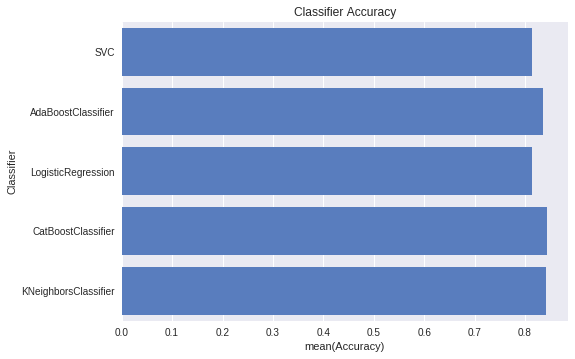

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from catboost import CatBoostClassifier


from sklearn.model_selection import train_test_split

#X_train0, X_test0, y_train0, y_test0 = train_test_split(train.drop(["Survived"], axis=1), train["Survived"], test_size=0.1, random_state=42)

#{'CatBoostClassifier': 0.8233333333333335,
# 'GradientBoostingClassifier': 0.8188888888888888,
# 'LinearDiscriminantAnalysis': 0.7933333333333332,
#'AdaBoostClassifier': 0.8377777777777776,
# 'CatBoostClassifier': 0.8422222222222222,
# 'GaussianNB': 0.7777777777777777,
# 'KNeighborsClassifier': 0.8422222222222221,
# 'SVC': 0.8133333333333332}
# 'LogisticRegression': 0.7944444444444443,
# 'RandomForestClassifier': 0.8088888888888889,
# 'SGDClassifier': 0.7944444444444444,
# 'SVC': 0.8122222222222222}

classifiers = [
    #KNeighborsClassifier(algorithm='brute', n_neighbors= 3, p= 1, weights='uniform'),
    #SVC(probability=True, C= 1, gamma = 0.1, kernel= 'rbf'),
    SVC(C=9.062264858625882, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.5565289675398223, kernel='rbf', max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001, verbose=False),
    #DecisionTreeClassifier(),
    #RandomForestClassifier(criterion= 'gini', max_depth=10, max_features= 'log2', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 200),
    #SGDClassifier(alpha= 0.001, l1_ratio= 0.8, learning_rate='optimal', loss='log', max_iter= 1000, penalty= 'elasticnet', shuffle= True),
 	  AdaBoostClassifier(RandomForestClassifier(max_depth=6), n_estimators=48, learning_rate=1.0888, algorithm="SAMME.R"),
    #GradientBoostingClassifier(),
    #GaussianNB(),
    #LinearDiscriminantAnalysis(),
    #QuadraticDiscriminantAnalysis(),
    LogisticRegression(solver='newton-cg'),
    CatBoostClassifier(iterations=46, depth=6, learning_rate=0.1, loss_function='Logloss', logging_level='Verbose'),
    KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski', 
                           metric_params=None, n_jobs=1, n_neighbors=6, p=2, 
                           weights='uniform')]

log_cols = ["Classifier", "Accuracy"]
log 	 = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

#X = train.drop(["Survived"], axis=1)
#y = train["Survived"]

acc_dict = {}

for train_index, test_index in sss.split(X, y):
	X_train, X_test = X[train_index], X[test_index]
	y_train, y_test = y[train_index], y[test_index]
	
	for clf in classifiers:
		name = clf.__class__.__name__
		clf.fit(X_train, y_train)
		train_predictions = clf.predict(X_test)
		acc = accuracy_score(y_test, train_predictions)
		if name in acc_dict:
			acc_dict[name] += acc
		else:
			acc_dict[name] = acc

for clf in acc_dict:
	acc_dict[clf] = acc_dict[clf] / 10.0
	log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
	log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

In [145]:
acc_dict

{'AdaBoostClassifier': 0.8366666666666666,
 'CatBoostClassifier': 0.8433333333333334,
 'KNeighborsClassifier': 0.8422222222222221,
 'LogisticRegression': 0.8144444444444444,
 'SVC': 0.8133333333333332}

In [146]:
predictions = []

for clf in classifiers:
  predictions.append(clf.predict_proba(X)[:,1])
    
combined = np.sum(predictions, axis=0) / len(classifiers)     
rounded = np.round(combined)
 
acc = accuracy_score(y, rounded)
print("Predictions of X_train", acc)

Predictions of X_train 0.8720538720538721


In [0]:
import pandas as pd

predictions = []

for clf in classifiers:
  predictions.append(clf.predict_proba(test_df)[:,1])
    
combined = np.sum(predictions, axis=0) / len(classifiers)     
rounded = np.round(combined).astype(int)
 
temp = pd.read_csv("test.csv")

submission_df = {"PassengerId": temp['PassengerId'], "Survived": rounded}
submission = pd.DataFrame(submission_df)
submission.to_csv("submission_Ensemble_Voting1_section16.csv",index=False)

**Score of 0.76076**

## 16.2 - With XGBoost: Score of 0.80861


Based on https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn

In [149]:
!pip install xgboost

In [0]:
import numpy as np

from scipy.stats import uniform, randint


from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

In [0]:
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

In [0]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [153]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X, y)

y_pred = xgb_model.predict(X)

print(confusion_matrix(y, y_pred))

[[512  37]
 [ 84 258]]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [154]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scores = []

for train_index, test_index in kfold.split(X):   
    X_train0, X_test0= X[train_index], X[test_index]
    y_train0, y_test0 = y[train_index], y[test_index]

    xgb_model = xgb.XGBClassifier(objective="binary:logistic")
    xgb_model.fit(X_train0, y_train0)
    
    y_pred0 = xgb_model.predict(X_test0)
    
    scores.append(accuracy_score(y_test0, y_pred0))
    
display_scores(np.sqrt(scores))

Scores: [0.92452615 0.89943803 0.9451235  0.90255567 0.92408473]
Mean: 0.919
Std: 0.017


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi


**Early stopping**

In [155]:

# if more than one evaluation metric are given the last one is used for early stopping
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc")

X_train0, X_test0, y_train0, y_test0 = train_test_split(X, y, random_state=42)

xgb_model.fit(X_train0, y_train0, early_stopping_rounds=5, eval_set=[(X_test0, y_test0)])

y_pred0 = xgb_model.predict(X_test0)

accuracy_score(y_test0, y_pred0)

[0]	validation_0-auc:0.90244
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.90244
[2]	validation_0-auc:0.90244
[3]	validation_0-auc:0.90244
[4]	validation_0-auc:0.90244
[5]	validation_0-auc:0.90244
Stopping. Best iteration:
[0]	validation_0-auc:0.90244



/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8609865470852018

In [156]:
print("best score: {0}, best iteration: {1}, best ntree limit {2}".format(xgb_model.best_score, xgb_model.best_iteration, xgb_model.best_ntree_limit))

best score: 0.90244, best iteration: 0, best ntree limit 1


**Hyperparameter Searching**

In [157]:
xgb_model = xgb.XGBClassifier()

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X, y)

report_best_scores(search.cv_results_, 1)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Model with rank: 1
Mean validation score: 0.848 (std: 0.008)
Parameters: {'colsample_bytree': 0.9519366578369711, 'gamma': 0.43349688000576175, 'learning_rate': 0.15239534860945342, 'max_depth': 2, 'n_estimators': 102, 'subsample': 0.6924299186352285}



/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   26.6s finished


In [158]:
search

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=200, n_jobs=1,
          param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7faa88234710>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7faa88262860>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7faa881e90b8>, 'max_depth': <sci...x7faa8808db00>, 'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7faa8807b2b0>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
       

In [159]:
search.score(X_test0, y_test0)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8878923766816144

In [160]:
y_pred = search.predict(holdout)

temp = pd.DataFrame(pd.read_csv("test.csv")['PassengerId'])
temp['Survived'] = y_pred
temp.to_csv("submission_XGBoost_RandomSearch0.csv", index = False)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


**Score of 0.80861**

### 16.2.1  - Submition on Kaggle with Best Result of XGBoost: Score of 0.80861



![alt text](https://drive.google.com/uc?export=view&id=1KHk2xDOt8BvN8EHXu1nu6-sWop1ZvqSs)



## 16.3  - Best Results: KNN, CATBoost and XGBoost

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0:	learn: 0.6186050	total: 23.9ms	remaining: 1.08s
1:	learn: 0.5640954	total: 40ms	remaining: 880ms
2:	learn: 0.5258519	total: 58.4ms	remaining: 836ms
3:	learn: 0.4986069	total: 80.4ms	remaining: 844ms
4:	learn: 0.4867832	total: 97.3ms	remaining: 798ms
5:	learn: 0.4657114	total: 116ms	remaining: 775ms
6:	learn: 0.4528657	total: 135ms	remaining: 750ms
7:	learn: 0.4408081	total: 153ms	remaining: 726ms
8:	learn: 0.4364631	total: 170ms	remaining: 699ms
9:	learn: 0.4221056	total: 189ms	remaining: 680ms
10:	learn: 0.4112378	total: 211ms	remaining: 672ms
11:	learn: 0.4014254	total: 240ms	remaining: 680ms
12:	learn: 0.3947767	total: 259ms	remaining: 657ms
13:	learn: 0.3915908	total: 275ms	remaining: 627ms
14:	learn: 0.3870973	total: 293ms	remaining: 605ms
15:	learn: 0.3830173	total: 310ms	remaining: 581ms
16:	learn: 0.3759391	total: 333ms	remaining: 567ms
17:	learn: 0.3755881	total: 347ms	remaining: 540ms
18:	learn: 0.3687789	total: 366ms	remaining: 521ms
19:	learn: 0.3677725	total: 382ms	rema

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


8:	learn: 0.4238286	total: 166ms	remaining: 680ms
9:	learn: 0.4181220	total: 181ms	remaining: 652ms
10:	learn: 0.4147331	total: 200ms	remaining: 635ms
11:	learn: 0.4015879	total: 219ms	remaining: 619ms
12:	learn: 0.3962342	total: 234ms	remaining: 595ms
13:	learn: 0.3877144	total: 254ms	remaining: 580ms
14:	learn: 0.3850860	total: 269ms	remaining: 555ms
15:	learn: 0.3820149	total: 284ms	remaining: 532ms
16:	learn: 0.3803827	total: 302ms	remaining: 515ms
17:	learn: 0.3744080	total: 325ms	remaining: 505ms
18:	learn: 0.3738763	total: 339ms	remaining: 482ms
19:	learn: 0.3720733	total: 354ms	remaining: 460ms
20:	learn: 0.3705734	total: 373ms	remaining: 444ms
21:	learn: 0.3676653	total: 390ms	remaining: 426ms
22:	learn: 0.3660568	total: 409ms	remaining: 409ms
23:	learn: 0.3641992	total: 428ms	remaining: 393ms
24:	learn: 0.3596047	total: 449ms	remaining: 377ms
25:	learn: 0.3590611	total: 467ms	remaining: 359ms
26:	learn: 0.3575724	total: 484ms	remaining: 340ms
27:	learn: 0.3566588	total: 499ms

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


4:	learn: 0.4915942	total: 122ms	remaining: 1s
5:	learn: 0.4672894	total: 144ms	remaining: 961ms
6:	learn: 0.4532048	total: 165ms	remaining: 921ms
7:	learn: 0.4314320	total: 191ms	remaining: 907ms
8:	learn: 0.4179259	total: 219ms	remaining: 902ms
9:	learn: 0.4134612	total: 241ms	remaining: 867ms
10:	learn: 0.4031443	total: 275ms	remaining: 874ms
11:	learn: 0.4008164	total: 294ms	remaining: 834ms
12:	learn: 0.3918683	total: 332ms	remaining: 842ms
13:	learn: 0.3857823	total: 357ms	remaining: 817ms
14:	learn: 0.3834671	total: 385ms	remaining: 795ms
15:	learn: 0.3816471	total: 411ms	remaining: 771ms
16:	learn: 0.3801559	total: 437ms	remaining: 746ms
17:	learn: 0.3794609	total: 458ms	remaining: 713ms
18:	learn: 0.3762025	total: 480ms	remaining: 682ms
19:	learn: 0.3742112	total: 514ms	remaining: 668ms
20:	learn: 0.3721976	total: 541ms	remaining: 644ms
21:	learn: 0.3712982	total: 562ms	remaining: 613ms
22:	learn: 0.3675827	total: 593ms	remaining: 593ms
23:	learn: 0.3672322	total: 612ms	remain

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0:	learn: 0.6146934	total: 29.4ms	remaining: 1.32s
1:	learn: 0.5587683	total: 58.9ms	remaining: 1.29s
2:	learn: 0.5188622	total: 81ms	remaining: 1.16s
3:	learn: 0.5030403	total: 103ms	remaining: 1.08s
4:	learn: 0.4780029	total: 124ms	remaining: 1.01s
5:	learn: 0.4530725	total: 154ms	remaining: 1.03s
6:	learn: 0.4398858	total: 177ms	remaining: 984ms
7:	learn: 0.4212958	total: 212ms	remaining: 1s
8:	learn: 0.4162376	total: 243ms	remaining: 1s
9:	learn: 0.4057863	total: 266ms	remaining: 959ms
10:	learn: 0.3963137	total: 290ms	remaining: 924ms
11:	learn: 0.3855802	total: 322ms	remaining: 912ms
12:	learn: 0.3820294	total: 344ms	remaining: 873ms
13:	learn: 0.3790758	total: 365ms	remaining: 835ms
14:	learn: 0.3781403	total: 386ms	remaining: 798ms
15:	learn: 0.3736090	total: 416ms	remaining: 779ms
16:	learn: 0.3721650	total: 450ms	remaining: 767ms
17:	learn: 0.3702927	total: 473ms	remaining: 735ms
18:	learn: 0.3683579	total: 500ms	remaining: 711ms
19:	learn: 0.3670152	total: 527ms	remaining: 6

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


1:	learn: 0.5686492	total: 53.3ms	remaining: 1.17s
2:	learn: 0.5325102	total: 74.6ms	remaining: 1.07s
3:	learn: 0.5055878	total: 98.9ms	remaining: 1.04s
4:	learn: 0.4762214	total: 131ms	remaining: 1.07s
5:	learn: 0.4584722	total: 153ms	remaining: 1.02s
6:	learn: 0.4432653	total: 180ms	remaining: 1s
7:	learn: 0.4307935	total: 207ms	remaining: 984ms
8:	learn: 0.4161237	total: 238ms	remaining: 978ms
9:	learn: 0.4088706	total: 263ms	remaining: 946ms
10:	learn: 0.3991765	total: 295ms	remaining: 938ms
11:	learn: 0.3919750	total: 323ms	remaining: 916ms
12:	learn: 0.3871555	total: 350ms	remaining: 889ms
13:	learn: 0.3842563	total: 377ms	remaining: 862ms
14:	learn: 0.3832899	total: 403ms	remaining: 833ms
15:	learn: 0.3824359	total: 423ms	remaining: 793ms
16:	learn: 0.3800536	total: 449ms	remaining: 766ms
17:	learn: 0.3752685	total: 480ms	remaining: 746ms
18:	learn: 0.3731930	total: 506ms	remaining: 719ms
19:	learn: 0.3714327	total: 532ms	remaining: 692ms
20:	learn: 0.3701950	total: 559ms	remain

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


1:	learn: 0.6143095	total: 46.3ms	remaining: 1.02s
2:	learn: 0.5652173	total: 78.1ms	remaining: 1.12s
3:	learn: 0.5304217	total: 105ms	remaining: 1.11s
4:	learn: 0.5075829	total: 132ms	remaining: 1.08s
5:	learn: 0.4796479	total: 156ms	remaining: 1.04s
6:	learn: 0.4589515	total: 189ms	remaining: 1.05s
7:	learn: 0.4426289	total: 215ms	remaining: 1.02s
8:	learn: 0.4339767	total: 242ms	remaining: 996ms
9:	learn: 0.4281289	total: 268ms	remaining: 966ms
10:	learn: 0.4181935	total: 295ms	remaining: 940ms
11:	learn: 0.4106860	total: 318ms	remaining: 900ms
12:	learn: 0.4021151	total: 349ms	remaining: 887ms
13:	learn: 0.3955178	total: 381ms	remaining: 870ms
14:	learn: 0.3912775	total: 408ms	remaining: 844ms
15:	learn: 0.3870318	total: 430ms	remaining: 807ms
16:	learn: 0.3860664	total: 452ms	remaining: 771ms
17:	learn: 0.3827249	total: 488ms	remaining: 758ms
18:	learn: 0.3762081	total: 523ms	remaining: 743ms
19:	learn: 0.3734656	total: 556ms	remaining: 723ms
20:	learn: 0.3731522	total: 581ms	rema

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


3:	learn: 0.5127903	total: 104ms	remaining: 1.09s
4:	learn: 0.4858627	total: 127ms	remaining: 1.04s
5:	learn: 0.4656266	total: 149ms	remaining: 994ms
6:	learn: 0.4472707	total: 171ms	remaining: 953ms
7:	learn: 0.4369407	total: 194ms	remaining: 921ms
8:	learn: 0.4278668	total: 217ms	remaining: 893ms
9:	learn: 0.4149031	total: 243ms	remaining: 875ms
10:	learn: 0.4068021	total: 277ms	remaining: 883ms
11:	learn: 0.4034101	total: 300ms	remaining: 849ms
12:	learn: 0.4018708	total: 326ms	remaining: 828ms
13:	learn: 0.3970700	total: 355ms	remaining: 813ms
14:	learn: 0.3949165	total: 382ms	remaining: 790ms
15:	learn: 0.3920035	total: 409ms	remaining: 767ms
16:	learn: 0.3899441	total: 436ms	remaining: 744ms
17:	learn: 0.3886030	total: 464ms	remaining: 722ms
18:	learn: 0.3877466	total: 491ms	remaining: 698ms
19:	learn: 0.3830271	total: 523ms	remaining: 679ms
20:	learn: 0.3763511	total: 555ms	remaining: 661ms
21:	learn: 0.3746733	total: 582ms	remaining: 634ms
22:	learn: 0.3735971	total: 609ms	rema

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


4:	learn: 0.4880212	total: 122ms	remaining: 1s
5:	learn: 0.4662943	total: 146ms	remaining: 971ms
6:	learn: 0.4513174	total: 167ms	remaining: 930ms
7:	learn: 0.4403589	total: 200ms	remaining: 951ms
8:	learn: 0.4338444	total: 222ms	remaining: 911ms
9:	learn: 0.4307248	total: 242ms	remaining: 870ms
10:	learn: 0.4175539	total: 267ms	remaining: 850ms
11:	learn: 0.4065790	total: 293ms	remaining: 830ms
12:	learn: 0.4001660	total: 316ms	remaining: 802ms
13:	learn: 0.3974870	total: 341ms	remaining: 779ms
14:	learn: 0.3947791	total: 367ms	remaining: 759ms
15:	learn: 0.3898582	total: 396ms	remaining: 742ms
16:	learn: 0.3852079	total: 421ms	remaining: 718ms
17:	learn: 0.3837356	total: 442ms	remaining: 688ms
18:	learn: 0.3800656	total: 464ms	remaining: 660ms
19:	learn: 0.3785050	total: 488ms	remaining: 634ms
20:	learn: 0.3748572	total: 510ms	remaining: 607ms
21:	learn: 0.3730970	total: 542ms	remaining: 591ms
22:	learn: 0.3710846	total: 567ms	remaining: 567ms
23:	learn: 0.3692724	total: 594ms	remain

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0:	learn: 0.6381633	total: 22.8ms	remaining: 1.03s
1:	learn: 0.6083478	total: 42ms	remaining: 923ms
2:	learn: 0.5597673	total: 63.7ms	remaining: 913ms
3:	learn: 0.5172906	total: 90.6ms	remaining: 951ms
4:	learn: 0.4919873	total: 112ms	remaining: 919ms
5:	learn: 0.4679549	total: 140ms	remaining: 932ms
6:	learn: 0.4489468	total: 167ms	remaining: 931ms
7:	learn: 0.4324806	total: 203ms	remaining: 965ms
8:	learn: 0.4275717	total: 226ms	remaining: 929ms
9:	learn: 0.4154906	total: 251ms	remaining: 904ms
10:	learn: 0.4065752	total: 274ms	remaining: 872ms
11:	learn: 0.4024955	total: 296ms	remaining: 837ms
12:	learn: 0.3981844	total: 317ms	remaining: 806ms
13:	learn: 0.3931143	total: 344ms	remaining: 787ms
14:	learn: 0.3896523	total: 373ms	remaining: 772ms
15:	learn: 0.3782335	total: 406ms	remaining: 761ms
16:	learn: 0.3730924	total: 438ms	remaining: 746ms
17:	learn: 0.3713444	total: 466ms	remaining: 724ms
18:	learn: 0.3706298	total: 494ms	remaining: 701ms
19:	learn: 0.3700501	total: 516ms	remai

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


2:	learn: 0.5451324	total: 74.2ms	remaining: 1.06s
3:	learn: 0.5110133	total: 103ms	remaining: 1.08s
4:	learn: 0.4868983	total: 126ms	remaining: 1.03s
5:	learn: 0.4630496	total: 158ms	remaining: 1.05s
6:	learn: 0.4447503	total: 180ms	remaining: 1s
7:	learn: 0.4349575	total: 206ms	remaining: 977ms
8:	learn: 0.4282083	total: 227ms	remaining: 934ms
9:	learn: 0.4121485	total: 255ms	remaining: 918ms
10:	learn: 0.4052003	total: 287ms	remaining: 912ms
11:	learn: 0.4013589	total: 308ms	remaining: 872ms
12:	learn: 0.3946451	total: 333ms	remaining: 846ms
13:	learn: 0.3921475	total: 355ms	remaining: 811ms
14:	learn: 0.3888451	total: 379ms	remaining: 783ms
15:	learn: 0.3839785	total: 405ms	remaining: 759ms
16:	learn: 0.3827939	total: 426ms	remaining: 726ms
17:	learn: 0.3794192	total: 450ms	remaining: 700ms
18:	learn: 0.3763381	total: 473ms	remaining: 672ms
19:	learn: 0.3726013	total: 499ms	remaining: 649ms
20:	learn: 0.3681519	total: 523ms	remaining: 623ms
21:	learn: 0.3679521	total: 544ms	remaini

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


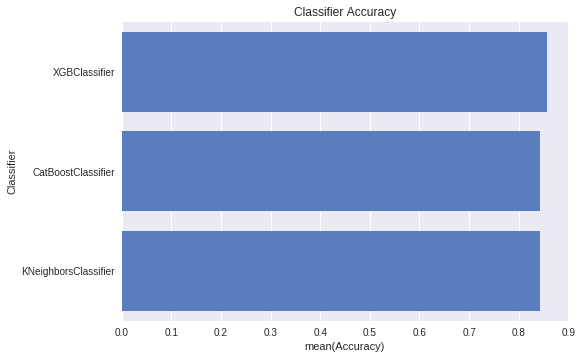

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from catboost import CatBoostClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split

#X_train0, X_test0, y_train0, y_test0 = train_test_split(train.drop(["Survived"], axis=1), train["Survived"], test_size=0.1, random_state=42)


classifiers = [
    xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
    CatBoostClassifier(iterations=46, depth=6, learning_rate=0.1, loss_function='Logloss', logging_level='Verbose'),
    KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski', 
                           metric_params=None, n_jobs=1, n_neighbors=6, p=2, 
                           weights='uniform')]

log_cols = ["Classifier", "Accuracy"]
log 	 = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

#X = train.drop(["Survived"], axis=1)
#y = train["Survived"]

acc_dict = {}

for train_index, test_index in sss.split(X, y):
	X_train, X_test = X[train_index], X[test_index]
	y_train, y_test = y[train_index], y[test_index]
	
	for clf in classifiers:
		name = clf.__class__.__name__
		clf.fit(X_train, y_train)
		train_predictions = clf.predict(X_test)
		acc = accuracy_score(y_test, train_predictions)
		if name in acc_dict:
			acc_dict[name] += acc
		else:
			acc_dict[name] = acc

for clf in acc_dict:
	acc_dict[clf] = acc_dict[clf] / 10.0
	log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
	log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

In [162]:
acc_dict

{'CatBoostClassifier': 0.8433333333333334,
 'KNeighborsClassifier': 0.8422222222222221,
 'XGBClassifier': 0.8566666666666667}

In [163]:
predictions = []

for clf in classifiers:
  predictions.append(clf.predict_proba(X)[:,1])
    
combined = np.sum(predictions, axis=0) / len(classifiers)     
rounded = np.round(combined)
 
acc = accuracy_score(y, rounded)
print("Predictions of X_train", acc)

Predictions of X_train 0.8653198653198653


In [0]:
import pandas as pd

predictions = []

for clf in classifiers:
  predictions.append(clf.predict_proba(holdout)[:,1])
    
combined = np.sum(predictions, axis=0) / len(classifiers)     
rounded = np.round(combined).astype(int)
 
temp = pd.read_csv("test.csv")

submission_df = {"PassengerId": temp['PassengerId'], "Survived": rounded}
submission = pd.DataFrame(submission_df)
submission.to_csv("submission_Voting_CatBoost_KNN_XGB.csv",index=False)

### 16.3.1 Submition on Kaggle with Voting: score of 0.79425


![alt text](https://drive.google.com/uc?export=view&id=1FD9RVt-RM-lfAR0ynVfOmcMO9mCzX4rk)

